# **Importing the modules**

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection
from sklearn.ensemble import StackingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score, precision_score, recall_score, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import matthews_corrcoef
from category_encoders import WOEEncoder, BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split, StratifiedKFold, LeaveOneOut, cross_validate
import pickle
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
##from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

# **Load dataset**

In [2]:
ML_data = pd.read_csv("ML_UG_dataset.csv", sep = ",")
Val_data = pd.read_csv("ML_SA_dataset.csv", sep = ",")
print(ML_data.shape)
print(ML_data.dtypes)
ML_data.head(2)

(182, 5003)
Unnamed: 0      int64
Sample         object
HIV STATUS      int64
AGE             int64
SEX             int64
                ...  
POS_4408920     int64
POS_4408923     int64
POS_4409954     int64
POS_4410386     int64
POS_4411016     int64
Length: 5003, dtype: object


,Unnamed: 0,Sample,HIV STATUS,AGE,SEX,STM,INH,RIF,EMB,POS_371,...,POS_4407873,POS_4407927,POS_4408048,POS_4408087,POS_4408156,POS_4408920,POS_4408923,POS_4409954,POS_4410386,POS_4411016
0,0,ERR038736,0,30,0,0,1,1,1,0,...,0,0,0,0,1,0,0,0,0,0
1,1,ERR038737,0,23,1,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [3]:
Val_data.head()

,Unnamed: 0,Sample,AGE,SEX,HIV STATUS,INH,RIF,EMB,STM,POS_371,...,POS_4407873,POS_4407927,POS_4408048,POS_4408087,POS_4408156,POS_4408920,POS_4408923,POS_4409954,POS_4410386,POS_4411016
0,0,SRR9971303,23,0,1.0,1,1,1,1,0,...,0,0,0,0,1,0,0,0,0,0
1,1,SRR9971318,51,1,0.0,1,1,1,1,0,...,0,1,0,0,0,0,1,0,0,0
2,2,SRR9971302,28,1,0.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,3,SRR9971120,27,1,0.0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,4,SRR9971317,44,1,0.0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0


# **Converting the columns to the correct data types**

In [4]:
# Select columns with the common prefix 'POS'
pos_columns = ML_data.filter(like='POS')

# Convert selected columns to categorical
ML_data[pos_columns.columns] = pos_columns.astype('category')

ML_data['SEX']= ML_data['SEX'].astype('category')
#ML_data['HIV STATUS']=ML_data['HIV STATUS'].astype(int)
ML_data['HIV STATUS']=ML_data['HIV STATUS'].astype('category')
# Converted the Age column to integer 
ML_data['AGE']= ML_data['AGE'].astype(int)
ML_data['RIF']= ML_data['RIF'].astype('category')
ML_data['INH']= ML_data['INH'].astype('category')
ML_data['STM']= ML_data['STM'].astype('category')
ML_data['EMB']= ML_data['EMB'].astype('category')


In [5]:
# Select columns with the common prefix 'POS'
pos_columns = Val_data.filter(like='POS')

# Convert selected columns to categorical
Val_data[pos_columns.columns] = pos_columns.astype('category')

Val_data['SEX']= Val_data['SEX'].astype('category')
#ML_data['HIV STATUS']=ML_data['HIV STATUS'].astype(int)
Val_data['HIV STATUS']=Val_data['HIV STATUS'].astype('category')
# Converted the Age column to integer 
Val_data['AGE']= Val_data['AGE'].astype(int)
Val_data['RIF']= Val_data['RIF'].astype('category')
Val_data['INH']= Val_data['INH'].astype('category')
Val_data['STM']= Val_data['STM'].astype('category')
Val_data['EMB']= Val_data['EMB'].astype('category')

# **Missing value check**

In [6]:
ML_data.isna().sum()

Unnamed: 0     0
Sample         0
HIV STATUS     0
AGE            0
SEX            0
              ..
POS_4408920    0
POS_4408923    0
POS_4409954    0
POS_4410386    0
POS_4411016    0
Length: 5003, dtype: int64

In [7]:
Val_data.isna().sum()

Unnamed: 0     0
Sample         0
AGE            0
SEX            0
HIV STATUS     2
              ..
POS_4408920    0
POS_4408923    0
POS_4409954    0
POS_4410386    0
POS_4411016    0
Length: 5003, dtype: int64

# **Seperating the Features and target**

In [8]:
# Remove columns starting with 'POS'
#ML_data = ML_data.loc[:, ~ML_data.columns.str.startswith('POS')]


In [9]:

Columns_to_be_deleted= ['Sample', 'Unnamed: 0', 'INH', 'STM', 'EMB']

RIF_data = ML_data.drop( Columns_to_be_deleted, axis=1)
Val_data = Val_data.drop( Columns_to_be_deleted, axis=1)

X= RIF_data.drop('RIF', axis=True)
Y= RIF_data['RIF']

X.shape, Y.shape



((182, 4997), (182,))

In [10]:
Y.value_counts()

1    120
0     62
Name: RIF, dtype: int64

In [11]:
X.head(n=4)

,HIV STATUS,AGE,SEX,POS_371,POS_1228,POS_1552,POS_1849,POS_1977,POS_2532,POS_3446,...,POS_4407873,POS_4407927,POS_4408048,POS_4408087,POS_4408156,POS_4408920,POS_4408923,POS_4409954,POS_4410386,POS_4411016
0,0,30,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,23,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,20,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,27,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
Val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Columns: 4998 entries, AGE to POS_4411016
dtypes: category(4997), int64(1)
memory usage: 1.7 MB


In [13]:
missing_rows = Val_data[Val_data['HIV STATUS'].isna()]
missing_rows.head()
# Assuming X is a pandas DataFrame
Val_data = Val_data.dropna(subset=['HIV STATUS'])

In [14]:
Val_data.head()
X_val= Val_data.drop('RIF', axis=True)
Y_val= Val_data['RIF']

X_val.shape, Y_val.shape


((236, 4997), (236,))

In [15]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236 entries, 0 to 237
Columns: 4997 entries, AGE to POS_4411016
dtypes: category(4996), int64(1)
memory usage: 1.7 MB


In [16]:
Y_val.value_counts()

1    210
0     26
Name: RIF, dtype: int64

# **Splitting the dataset**

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, stratify=Y, test_size=0.2, random_state=42
)

In [18]:
X_train.shape, X_test.shape

((145, 4997), (37, 4997))

In [19]:
y_train.value_counts()

1    96
0    49
Name: RIF, dtype: int64

In [20]:
y_test.value_counts()

1    24
0    13
Name: RIF, dtype: int64

 # **Listing the classification models**

In [21]:
model_rf = RandomForestClassifier()
model_logr =LogisticRegression(random_state=0)
#model_lgbm = LGBMClassifier(random_state=0, n_jobs = -1)
model_xgb = XGBClassifier(random_state=0)
model_gbc = GradientBoostingClassifier(random_state=0)
model_cat = CatBoostClassifier(verbose=False)
model_dt = DecisionTreeClassifier()
model_et = ExtraTreesClassifier()
model_svm = SVC(probability=True)
model_ada = AdaBoostClassifier(random_state=0)
#model_knn = KNeighborsClassifier()
#model_gNB =  GaussianNB()
model_nn= MLPClassifier(random_state=1)


models = []
models.append(('Logistic regression', model_logr))
models.append(('Suport Vector Machine', model_svm))
models.append(('Decision trees', model_dt))
models.append(('Random Forest', model_rf))
models.append(('Ada Boost', model_ada))
models.append(('Gradient Boosting', model_gbc))
models.append(('ExtraTrees Classifier', model_et))
#models.append(('BC', BaggingClassifier()))
#models.append(('LGBM', model_lgbm))
models.append(('CatBoost', model_cat))
models.append(('XGBoost', model_xgb))
models.append(('MLP', model_nn))


In [22]:
model_rf = RandomForestClassifier(random_state=0)
model_logr =LogisticRegression(random_state=0)
#model_lgbm = LGBMClassifier(random_state=0, n_jobs = -1)
model_xgb = XGBClassifier(random_state=0)
model_gbc = GradientBoostingClassifier(random_state=0)
model_cat = CatBoostClassifier(verbose=False)
model_dt = DecisionTreeClassifier(random_state=0)
model_et = ExtraTreesClassifier(random_state=0)
model_svm = SVC(probability =True)
model_ada = AdaBoostClassifier(random_state=0)
#model_knn = KNeighborsClassifier()
#model_gNB =  GaussianNB()
model_nn= MLPClassifier(random_state=1)


models = []
models.append(('LR', model_logr))
models.append(('SVM', model_svm))
models.append(('DT', model_dt))
models.append(('RF', model_rf))
models.append(('AdaBoost', model_ada))
models.append(('GBC', model_gbc))
models.append(('ETC', model_et))
models.append(('CatBoost', model_cat))
models.append(('XGBoost', model_xgb))
models.append(('MLP', model_nn))


# **Preparing pipeline steps**

In [24]:
#categorical_columns = ['SEX', 'HIV STATUS']

In [20]:
categorical_prefix = 'POS'
categorical_columns = [col for col in X.columns if col.startswith(categorical_prefix)]
# Add other categorical columns with different prefixes
categorical_columns += ['SEX', 'HIV STATUS']

cat_var = categorical_columns.copy()

# Numerical variable
con_var = ['AGE']

In [24]:
print(cat_var)

['POS_371', 'POS_1228', 'POS_1552', 'POS_1849', 'POS_1977', 'POS_2532', 'POS_3446', 'POS_4013', 'POS_5078', 'POS_6112', 'POS_6140', 'POS_6815', 'POS_7362', 'POS_7572', 'POS_7582', 'POS_7585', 'POS_8040', 'POS_8056', 'POS_8452', 'POS_9143', 'POS_9304', 'POS_10741', 'POS_11370', 'POS_11820', 'POS_11879', 'POS_12204', 'POS_13069', 'POS_13298', 'POS_13460', 'POS_14251', 'POS_14401', 'POS_14785', 'POS_14861', 'POS_15117', 'POS_16119', 'POS_17608', 'POS_17609', 'POS_17654', 'POS_21795', 'POS_21819', 'POS_22961', 'POS_23174', 'POS_24007', 'POS_25610', 'POS_26347', 'POS_26747', 'POS_26957', 'POS_26959', 'POS_27439', 'POS_27463', 'POS_27469', 'POS_27487', 'POS_27996', 'POS_28139', 'POS_28366', 'POS_28536', 'POS_28640', 'POS_29482', 'POS_29641', 'POS_30519', 'POS_30688', 'POS_30943', 'POS_31077', 'POS_32103', 'POS_32349', 'POS_32355', 'POS_33436', 'POS_33457', 'POS_33551', 'POS_33670', 'POS_33841', 'POS_34044', 'POS_34527', 'POS_34568', 'POS_34859', 'POS_35097', 'POS_35608', 'POS_36008', 'POS_36

In [21]:
from sklearn.feature_selection import SelectFromModel
scaler = StandardScaler()
onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
#feature = SelectFromModel(model_rf, threshold=0.001)
ct = ColumnTransformer([('onehot', onehot, cat_var),
                        ('scaler', scaler, con_var)], remainder='passthrough', n_jobs=-1)

**cross validation**

In [28]:
# Setting the StratifiedKFold parameter
skfold = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, matthews_corrcoef, confusion_matrix
from scipy.stats import sem
from sklearn.pipeline import Pipeline

# Function to calculate confidence interval with bootstrapping
def bootstrap_confidence_interval(data, confidence=0.95, n_bootstrap=1000):
    means = []
    
    # Bootstrapping: sample with replacement and compute mean for each sample
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        means.append(np.mean(sample))
    
    # Calculate confidence interval using percentiles
    lower = np.percentile(means, (1 - confidence) / 2 * 100)
    upper = np.percentile(means, (1 + confidence) / 2 * 100)
    
    return np.mean(means), lower, upper

# Custom scorer for specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity_score)

# Cross-validation function
def cross_validate_metrics(models, X, y, cv=5, confidence=0.95, n_bootstrap=1000):
    skfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = ["accuracy", "precision", "recall", "f1", "roc_auc", "mcc", "specificity"]
    
    score_lists = {score: [] for score in scores}
    results = []
    
    for i, (name, classifier) in enumerate(models):
        print(name)
        
        pipe = Pipeline([('ct', ct), (name, classifier)])  # Assuming `ct` is a predefined ColumnTransformer
        model_results = {score: [] for score in scores}
        model_results['model'] = name
        
        for score in scores:
            if score == "mcc":
                cv_scores = cross_val_score(pipe, X, y, cv=skfold, scoring=make_scorer(matthews_corrcoef))
            elif score == "specificity":
                cv_scores = cross_val_score(pipe, X, y, cv=skfold, scoring=specificity_scorer)
            else:
                cv_scores = cross_val_score(pipe, X, y, cv=skfold, scoring=score)
            
            model_results[score] = cv_scores
            score_lists[score].append(cv_scores)
            print(f"{score} : {np.mean(cv_scores):.4f}")
        
        # Calculate mean, std and bootstrap confidence intervals for each metric
        summary = {'model': name}
        for metric in scores:
            mean, lower_ci, upper_ci = bootstrap_confidence_interval(model_results[metric], confidence, n_bootstrap)
            summary[f'{metric}_mean'] = mean
            summary[f'{metric}_std'] = np.std(model_results[metric])
            summary[f'{metric}_ci_lower'] = lower_ci
            summary[f'{metric}_ci_upper'] = upper_ci
        
        results.append(summary)
        print("\n")
    
    return pd.DataFrame(results)

# Example usage (assuming models, X, and y are defined)
# results_df = cross_validate_metrics(models, X, y)


In [32]:
# Perform cross-validation and get the results
results_df = cross_validate_metrics(models, X, Y, cv=5, confidence=0.95)
print(results_df)

results_df.head(n=10)

LR


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

accuracy : 0.8686


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

precision : 0.9209


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

recall : 0.8833


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

f1 : 0.8975


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

roc_auc : 0.9276


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

mcc : 0.7268


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

specificity : 0.8385


SVM


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.6486


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.6646


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.9417


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.7781


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.7993


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.0237


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.0769


DT


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.7959


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8592


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8250


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8380


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.7837


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.5717


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.7423


RF


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.7911


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8616


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8167


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8369


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.8743


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.5488


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.7397


AdaBoost


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8188


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.9074


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8083


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8521


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.8413


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.6295


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.8372


GBC


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8297


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8743


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8750


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8713


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9166


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.6277


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.7410


ETC


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8245


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8866


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8417


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8619


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.8998


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.6238


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.7897


CatBoost


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8462


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8690


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.9083


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8864


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9267


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.6550


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.7244


XGBoost


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8677


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8918


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.9167


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.9018


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9320


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.7074


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.7731


MLP


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

accuracy : 0.5989


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

precision : 0.6851


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

recall : 0.5500


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

f1 : 0.5282


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

roc_auc : 0.6585


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

mcc : 0.2570


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

specificity : 0.6833


      model  accuracy_mean  accuracy_std  accuracy_ci_lower  \
0        LR       0.868535      0.045839           0.831828   
1       SVM       0.648829      0.022067           0.630631   
2        DT       0.796329      0.080596           0.728829   
3        RF       0.791853      0.051356           0.745323   
4  AdaBoost       0.818645      0.056264           0.768018   
5       GBC       0.829768      0.020029           0.813213   
6       ETC       0.823934      0.049872           0.781381   
7  CatBoost       0.847236      0.027700           0.823123   
8   XGBoost       0.866996      0.041318           0.838889   
9       MLP       0.599454      0.194884           0.429429   

   accuracy_ci_upper  precision_mean  precision_std  precision_ci_lower  \
0           0.911134        0.920403       0.061488            0.870508   
1           0.666667        0.664448       0.004167            0.660417   
2           0.863063        0.859039       0.019373       

,model,accuracy_mean,accuracy_std,accuracy_ci_lower,accuracy_ci_upper,precision_mean,precision_std,precision_ci_lower,precision_ci_upper,recall_mean,...,roc_auc_ci_lower,roc_auc_ci_upper,mcc_mean,mcc_std,mcc_ci_lower,mcc_ci_upper,specificity_mean,specificity_std,specificity_ci_lower,specificity_ci_upper
0,LR,0.868535,0.045839,0.831828,0.911134,0.920403,0.061488,0.870508,0.971292,0.882575,...,0.889209,0.966026,0.726595,0.091496,0.653805,0.813532,0.838105,0.147820,0.703846,0.951314
1,SVM,0.648829,0.022067,0.630631,0.666667,0.664448,0.004167,0.660417,0.666667,0.939425,...,0.706303,0.895673,0.023560,0.031379,0.000000,0.054937,0.075308,0.097301,0.000000,0.154231
2,DT,0.796329,0.080596,0.728829,0.863063,0.859039,0.019373,0.842842,0.876344,0.823808,...,0.731731,0.835665,0.570625,0.153965,0.447012,0.705759,0.742508,0.026086,0.715385,0.761538
3,RF,0.791853,0.051356,0.745323,0.835586,0.862556,0.043849,0.824184,0.898398,0.816542,...,0.823157,0.924733,0.548862,0.112686,0.453846,0.645955,0.739526,0.100753,0.650000,0.825641
4,AdaBoost,0.818645,0.056264,0.768018,0.868168,0.907632,0.027522,0.879437,0.929857,0.808350,...,0.813782,0.868910,0.628051,0.098287,0.530200,0.712879,0.837574,0.054934,0.785897,0.887179
5,GBC,0.829768,0.020029,0.813213,0.847147,0.874156,0.053685,0.826045,0.921429,0.873542,...,0.893590,0.940972,0.627145,0.054653,0.577687,0.678206,0.736627,0.143143,0.607692,0.855128
6,ETC,0.823934,0.049872,0.781381,0.866667,0.886557,0.030468,0.857895,0.910831,0.842658,...,0.858387,0.941186,0.622939,0.095538,0.534768,0.706919,0.790741,0.067158,0.723077,0.838462
7,CatBoost,0.847236,0.027700,0.823123,0.872222,0.869353,0.045349,0.827862,0.906303,0.908883,...,0.904844,0.945673,0.656144,0.066418,0.596140,0.713659,0.724254,0.125484,0.615192,0.819231
8,XGBoost,0.866996,0.041318,0.838889,0.907207,0.890289,0.054639,0.844312,0.938095,0.915267,...,0.897276,0.966720,0.706784,0.095829,0.636943,0.795112,0.771806,0.131284,0.670256,0.885897
9,MLP,0.599454,0.194884,0.429429,0.768468,0.683943,0.366996,0.333333,0.951724,0.549383,...,0.518056,0.825481,0.256317,0.272037,0.034300,0.509217,0.685100,0.409607,0.283333,1.000000


In [33]:
results_df.to_csv("RIF_Cross_val_scores_Combined_dataset.csv")

In [22]:
# Exclude specific columns
columns_to_exclude = ['AGE', 'SEX', 'HIV STATUS']
SNP_data = X.drop(columns=columns_to_exclude)

# Display the new dataset
SNP_data.head()

,POS_371,POS_1228,POS_1552,POS_1849,POS_1977,POS_2532,POS_3446,POS_4013,POS_5078,POS_6112,...,POS_4407873,POS_4407927,POS_4408048,POS_4408087,POS_4408156,POS_4408920,POS_4408923,POS_4409954,POS_4410386,POS_4411016
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
categorical_prefix = 'POS'
categorical_columns = [col for col in SNP_data.columns if col.startswith(categorical_prefix)]
cat_var2 = categorical_columns.copy()

In [25]:
onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)
ct = ColumnTransformer([('onehot', onehot, cat_var2)], remainder='passthrough', n_jobs=-1)

In [37]:
# Perform cross-validation and get the results
results_df = cross_validate_metrics(models, SNP_data, Y, cv=5, confidence=0.95)
print(results_df)

results_df.head(n=10)

LR


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

accuracy : 0.8629


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

precision : 0.9211


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

recall : 0.8750


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

f1 : 0.8930


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

roc_auc : 0.9231


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

mcc : 0.7130


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

specificity : 0.8385


SVM


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.9417


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.7781


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.7871


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.0237


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.0769


DT


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.7743


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8524


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8000


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8211


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.7628


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.5241


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


accuracy : 0.8134


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8687


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8500


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8568


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.8633


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.5914


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.7397


AdaBoost


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.7914


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8730


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8083


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8355


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.8351


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.5583


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.7577


GBC


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8296


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8757


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8750


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8717


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.8926


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.6272


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.7410


ETC


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8135


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8872


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8250


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8523


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.8867


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.6046


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.7885


CatBoost


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8459


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8742


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.9083


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8876


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9003


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.6516


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be

specificity : 0.7218


XGBoost


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8293


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8797


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8750


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8726


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.8865


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.6252


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.7385


MLP


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.4794


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarni

precision : 0.2853


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.3583


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.3151


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.5458


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.0597


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.7000


      model  accuracy_mean  accuracy_std  accuracy_ci_lower  \
0        LR       0.863588      0.037835           0.830631   
1       SVM       0.648577      0.022067           0.630631   
2        DT       0.773706      0.045887           0.734535   
3        RF       0.812608      0.031069           0.786787   
4  AdaBoost       0.790439      0.036025           0.766366   
5       GBC       0.830010      0.040928           0.797571   
6       ETC       0.813304      0.029965           0.788138   
7  CatBoost       0.845508      0.048981           0.795195   
8   XGBoost       0.828776      0.045413           0.789790   
9       MLP       0.482240      0.164585           0.344144   

   accuracy_ci_upper  precision_mean  precision_std  precision_ci_lower  \
0           0.895195        0.920145       0.062918            0.860161   
1           0.666667        0.664631       0.004167            0.660417   
2           0.816216        0.852736       0.026923       

,model,accuracy_mean,accuracy_std,accuracy_ci_lower,accuracy_ci_upper,precision_mean,precision_std,precision_ci_lower,precision_ci_upper,recall_mean,...,roc_auc_ci_lower,roc_auc_ci_upper,mcc_mean,mcc_std,mcc_ci_lower,mcc_ci_upper,specificity_mean,specificity_std,specificity_ci_lower,specificity_ci_upper
0,LR,0.863588,0.037835,0.830631,0.895195,0.920145,0.062918,0.860161,0.972082,0.875283,...,0.890433,0.955075,0.712644,0.079844,0.642725,0.782874,0.838523,0.147820,0.694872,0.952564
1,SVM,0.648577,0.022067,0.630631,0.666667,0.664631,0.004167,0.660417,0.666667,0.941342,...,0.687500,0.883173,0.023670,0.031379,0.000000,0.054937,0.078785,0.097301,0.000000,0.169231
2,DT,0.773706,0.045887,0.734535,0.816216,0.852736,0.026923,0.829259,0.877778,0.802192,...,0.740064,0.793269,0.524771,0.071543,0.471144,0.589686,0.726867,0.084206,0.650000,0.791058
3,RF,0.812608,0.031069,0.786787,0.839940,0.868255,0.044437,0.826429,0.901739,0.849708,...,0.826122,0.900534,0.590449,0.072751,0.522640,0.656325,0.741123,0.125327,0.619231,0.825641
4,AdaBoost,0.790439,0.036025,0.766366,0.827778,0.871991,0.058362,0.823077,0.925604,0.807067,...,0.790385,0.876389,0.558706,0.085638,0.481719,0.634202,0.757647,0.133752,0.639744,0.869231
5,GBC,0.830010,0.040928,0.797571,0.867417,0.875241,0.067485,0.820237,0.935498,0.876383,...,0.874679,0.913782,0.628570,0.099832,0.546697,0.712158,0.742690,0.166104,0.606250,0.884615
6,ETC,0.813304,0.029965,0.788138,0.840090,0.887081,0.037086,0.854598,0.922003,0.825217,...,0.844658,0.928793,0.604057,0.054144,0.560499,0.651186,0.787409,0.085811,0.716667,0.857692
7,CatBoost,0.845508,0.048981,0.795195,0.878529,0.875467,0.071382,0.804495,0.923619,0.907958,...,0.875694,0.923225,0.654823,0.129165,0.524219,0.735675,0.725997,0.203422,0.520513,0.857692
8,XGBoost,0.828776,0.045413,0.789790,0.868769,0.879710,0.084624,0.809231,0.950183,0.874208,...,0.846848,0.926229,0.625568,0.124065,0.516947,0.733378,0.743087,0.205424,0.571795,0.916667
9,MLP,0.482240,0.164585,0.344144,0.620270,0.279667,0.350705,0.000000,0.589333,0.358608,...,0.500000,0.612500,0.060413,0.119392,0.000000,0.179089,0.712600,0.400000,0.300000,1.000000


In [38]:
results_df.to_csv("RIF_Cross_val_scores_SNP_dataset_only.csv")

In [39]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled.shape, X_train.shape, y_resampled.shape, y_train.shape

((192, 4997), (145, 4997), (192,), (145,))

In [40]:
# Perform cross-validation and get the results
results_df = cross_validate_metrics(models, X_resampled, y_resampled, cv=5, confidence=0.95)
print(results_df)
results_df.head(n=10)

LR


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

accuracy : 0.8962


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

precision : 0.9084


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

recall : 0.8858


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

f1 : 0.8956


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

roc_auc : 0.9657


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

mcc : 0.7948


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

specificity : 0.9068


SVM


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.6671


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.7962


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.4884


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.5874


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.7958


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.3718


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.8442


DT


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8179


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8432


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.7811


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8089


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.8174


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.6393


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.8537


RF


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8756


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8969


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8558


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8713


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9460


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.7590


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.8968


AdaBoost


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8800


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.9095


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8437


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8747


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9320


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.7630


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.9168


GBC


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8703


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8910


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8442


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8652


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9544


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.7445


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.8963


ETC


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8808


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8969


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8663


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8776


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9568


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.7681


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.8968


CatBoost


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8494


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8691


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8237


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8448


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9550


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.7013


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.8758


XGBoost


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8962


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.9064


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8858


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8947


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9673


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.7945


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.9068


MLP


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

accuracy : 0.6405


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

precision : 0.4667


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

recall : 0.5158


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

f1 : 0.4720


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

roc_auc : 0.7812


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

mcc : 0.2897


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

specificity : 0.7700


      model  accuracy_mean  accuracy_std  accuracy_ci_lower  \
0        LR       0.896980      0.035604           0.866127   
1       SVM       0.666948      0.050499           0.630769   
2        DT       0.817988      0.045928           0.782186   
3        RF       0.875100      0.048749           0.830364   
4  AdaBoost       0.880349      0.036195           0.848448   
5       GBC       0.870220      0.062941           0.818623   
6       ETC       0.882868      0.051855           0.830364   
7  CatBoost       0.848688      0.061729           0.797841   
8   XGBoost       0.895377      0.042681           0.860189   
9       MLP       0.640102      0.178901           0.494872   

   accuracy_ci_upper  precision_mean  precision_std  precision_ci_lower  \
0           0.926316        0.909474       0.058167            0.858947   
1           0.717679        0.793418       0.128962            0.689555   
2           0.857895        0.842771       0.034689       

,model,accuracy_mean,accuracy_std,accuracy_ci_lower,accuracy_ci_upper,precision_mean,precision_std,precision_ci_lower,precision_ci_upper,recall_mean,...,roc_auc_ci_lower,roc_auc_ci_upper,mcc_mean,mcc_std,mcc_ci_lower,mcc_ci_upper,specificity_mean,specificity_std,specificity_ci_lower,specificity_ci_upper
0,LR,0.896980,0.035604,0.866127,0.926316,0.909474,0.058167,0.858947,0.959474,0.886117,...,0.946427,0.984931,0.794191,0.072708,0.732632,0.856911,0.907684,0.059815,0.863013,0.959474
1,SVM,0.666948,0.050499,0.630769,0.717679,0.793418,0.128962,0.689555,0.902857,0.488539,...,0.725521,0.862604,0.374016,0.109938,0.283509,0.471967,0.844200,0.123728,0.736842,0.936895
2,DT,0.817988,0.045928,0.782186,0.857895,0.842771,0.034689,0.813421,0.872982,0.781752,...,0.781053,0.857895,0.639713,0.089307,0.571129,0.726316,0.853872,0.040550,0.821053,0.887368
3,RF,0.875100,0.048749,0.830364,0.915789,0.897731,0.061259,0.840714,0.955000,0.855501,...,0.918532,0.973407,0.760216,0.094208,0.670583,0.836134,0.894617,0.063298,0.837895,0.957895
4,AdaBoost,0.880349,0.036195,0.848448,0.906883,0.909155,0.029241,0.885673,0.934503,0.845107,...,0.904898,0.961274,0.762280,0.070200,0.698560,0.816047,0.916723,0.024999,0.895789,0.937895
5,GBC,0.870220,0.062941,0.818623,0.921997,0.890227,0.060071,0.845175,0.947619,0.844661,...,0.930305,0.981330,0.743700,0.126778,0.640727,0.848209,0.895624,0.056284,0.854211,0.948947
6,ETC,0.882868,0.051855,0.830364,0.921053,0.897415,0.061259,0.845714,0.955000,0.865576,...,0.939211,0.974515,0.765675,0.100404,0.670583,0.847086,0.896263,0.063298,0.837895,0.957895
7,CatBoost,0.848688,0.061729,0.797841,0.901053,0.868944,0.062373,0.816078,0.922085,0.822842,...,0.931634,0.978947,0.698565,0.122692,0.596464,0.814353,0.875962,0.060432,0.825263,0.926316
8,XGBoost,0.895377,0.042681,0.860189,0.932254,0.906673,0.046230,0.867500,0.945395,0.886346,...,0.951801,0.982825,0.792628,0.084129,0.723977,0.865030,0.906230,0.049697,0.864737,0.947368
9,MLP,0.640102,0.178901,0.494872,0.798381,0.462167,0.413656,0.100000,0.800000,0.510526,...,0.664931,0.897839,0.281697,0.358747,0.000000,0.612776,0.769500,0.389358,0.400000,1.000000


In [41]:
results_df.to_csv("RIF_Cross_val_scores_Upsampled_combined dataset.csv")

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    SNP_data, Y, stratify=Y, test_size=0.2, random_state=42
)

In [27]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled.shape, X_train.shape, y_resampled.shape, y_train.shape

((192, 4994), (145, 4994), (192,), (145,))

In [33]:
# Perform cross-validation and get the results
results_df = cross_validate_metrics(models, X_resampled, y_resampled, cv=5, confidence=0.95)
print(results_df)

LR


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

accuracy : 0.9119


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

precision : 0.9040


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

recall : 0.9274


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

f1 : 0.9141


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

roc_auc : 0.9690


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

mcc : 0.8265


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

specificity : 0.8963


SVM


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.6412


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.6533


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.6789


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.6427


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.7670


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.3101


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.6053


DT


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8076


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8480


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.7495


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.7934


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.8074


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.6213


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.8653


RF


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8704


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8895


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8558


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8671


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9552


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.7497


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.8868


AdaBoost


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8753


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8840


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8658


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8741


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9346


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.7519


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.8853


GBC


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8601


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8878


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8237


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8536


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9540


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.7232


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.8963


ETC


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8703


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8905


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8558


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8670


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9586


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.7507


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.8868


CatBoost


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8704


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8750


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8658


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8696


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9524


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be

mcc : 0.7423


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.8758


XGBoost


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8756


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8820


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8653


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8724


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9582


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.7532


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

specificity : 0.8858


MLP


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochast

accuracy : 0.6632


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarni

precision : 0.3770


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochast

recall : 0.3474


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochast

f1 : 0.3609


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochast

roc_auc : 0.7474


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochast

mcc : 0.3282


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochast

specificity : 0.9789


      model  accuracy_mean  accuracy_std  accuracy_ci_lower  \
0        LR       0.913288      0.044501           0.875304   
1       SVM       0.641719      0.056796           0.596356   
2        DT       0.807120      0.061901           0.755601   
3        RF       0.869960      0.052758           0.820108   
4  AdaBoost       0.874729      0.054160           0.819433   
5       GBC       0.858916      0.063505           0.804318   
6       ETC       0.870366      0.044817           0.825641   
7  CatBoost       0.870304      0.057770           0.819838   
8   XGBoost       0.874833      0.059148           0.824831   
9       MLP       0.666399      0.201543           0.497436   

   accuracy_ci_upper  precision_mean  precision_std  precision_ci_lower  \
0           0.952632        0.904822       0.064774            0.849077   
1           0.691498        0.653227       0.089048            0.583238   
2           0.859514        0.846870       0.070545       

In [34]:
results_df.head(n=10)

,model,accuracy_mean,accuracy_std,accuracy_ci_lower,accuracy_ci_upper,precision_mean,precision_std,precision_ci_lower,precision_ci_upper,recall_mean,...,roc_auc_ci_lower,roc_auc_ci_upper,mcc_mean,mcc_std,mcc_ci_lower,mcc_ci_upper,specificity_mean,specificity_std,specificity_ci_lower,specificity_ci_upper
0,LR,0.913288,0.044501,0.875304,0.952632,0.904822,0.064774,0.849077,0.961429,0.927423,...,0.950055,0.987119,0.827960,0.089096,0.753677,0.899262,0.897198,0.073375,0.831579,0.968421
1,SVM,0.641719,0.056796,0.596356,0.691498,0.653227,0.089048,0.583238,0.739000,0.680616,...,0.692521,0.841551,0.309992,0.115581,0.215347,0.406178,0.601700,0.192663,0.426316,0.763289
2,DT,0.807120,0.061901,0.755601,0.859514,0.846870,0.070545,0.784503,0.905931,0.749505,...,0.753632,0.860000,0.619804,0.124369,0.507859,0.719291,0.864636,0.060798,0.812632,0.915789
3,RF,0.869960,0.052758,0.820108,0.915789,0.890430,0.072494,0.823636,0.955000,0.856177,...,0.927943,0.982825,0.749327,0.101930,0.661246,0.829172,0.886895,0.079646,0.807895,0.957895
4,AdaBoost,0.874729,0.054160,0.819433,0.911741,0.885322,0.050380,0.832632,0.922601,0.866466,...,0.898255,0.967313,0.751810,0.108467,0.640356,0.815278,0.884435,0.051825,0.832632,0.926316
5,GBC,0.858916,0.063505,0.804318,0.915789,0.886313,0.063031,0.839216,0.952941,0.824203,...,0.929058,0.980609,0.722041,0.127227,0.611687,0.834810,0.897575,0.056284,0.855789,0.948947
6,ETC,0.870366,0.044817,0.825641,0.905263,0.890700,0.069252,0.824565,0.953947,0.858137,...,0.934432,0.982825,0.749660,0.085432,0.672846,0.818233,0.885805,0.079646,0.807895,0.950197
7,CatBoost,0.870304,0.057770,0.819838,0.921053,0.875086,0.060076,0.826583,0.926725,0.865029,...,0.928194,0.976731,0.741713,0.114527,0.643548,0.842777,0.876084,0.060432,0.825263,0.926316
8,XGBoost,0.874833,0.059148,0.824831,0.926316,0.881058,0.041836,0.846646,0.917323,0.865154,...,0.938269,0.978947,0.755403,0.118867,0.650914,0.854421,0.884962,0.037792,0.854211,0.917368
9,MLP,0.666399,0.201543,0.497436,0.842105,0.372470,0.461707,0.000000,0.755921,0.348189,...,0.551773,0.915235,0.321328,0.404682,0.000000,0.686083,0.979453,0.025784,0.957895,1.000000


In [36]:
results_df.to_csv("RIF_Cross_val_scores_Upsampled_SNP_dataset.csv")

In [21]:
scores = ["accuracy", "precision", "recall", "f1",
          "roc_auc", "mcc"]
f1 = [] # To hold the f1-scores for each model
precision = [] # To hold the precision scores for each model
recall = [] # To hold the recall scores for each model
accuracy = [] # To hold the accuracy scores for each model
roc_auc = [] # To hold the roc_auc scores for each model
mcc = []
score_lists = [accuracy, precision, recall, f1, roc_auc, mcc]
for i, (name, classifier) in enumerate(models):
    print(name)
    pipe = Pipeline([('ct', ct), (name, classifier)])
    for index, score in enumerate(scores):
        if score == "mcc":
            cv_score = cross_val_score(pipe, X, Y, cv=skfold,  
                                       scoring=make_scorer(matthews_corrcoef))
        else:
            cv_score = cross_val_score(pipe, X, Y, cv=skfold, scoring=score)
        score_lists[index].append(cv_score)
        print(score + " : " + str(np.mean(cv_score)))
    print("\n")

Logistic regression


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

accuracy : 0.8686186186186186


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

precision : 0.9209000164989275


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

recall : 0.8833333333333332


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

f1 : 0.8974869794150754


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

roc_auc : 0.9276175213675215


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

mcc : 0.7267709485673528


Suport Vector Machine


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.6486486486486486


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.6645833333333332


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.9416666666666668


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.7781481481481481


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.7992521367521368


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.023683200030893463


Decision trees


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.7959459459459459


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8885084450256076


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.825


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.834659912191827


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.7711538461538463


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.6087486849681273


Random Forest


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.7969969969969971


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8744975845410629


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8416666666666668


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8426119053922081


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.8830929487179487


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.5965706552869616


Ada Boost


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8187687687687688


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.9074240763499075


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8083333333333333


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8520673420425231


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.8413461538461539


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.6295111330611495


Gradient Boosting


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8297297297297298


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8742800303145131


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.875


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8712515723270441


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9166132478632478


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.6277460396067517


ExtraTrees Classifier


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.807957957957958


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.885040912558075


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.8333333333333333


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8636110343557153


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.8952457264957264


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.63168244556859


CatBoost


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8462462462462463


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8690029740374567


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.9083333333333332


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.8864231192066654


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.926655982905983


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.6549823945291111


XGBoost


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

accuracy : 0.8677177177177178


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

precision : 0.8917989417989418


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

recall : 0.9166666666666666


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

f1 : 0.9017596782302665


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

roc_auc : 0.9319978632478632


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

mcc : 0.7074315554724514


MLP


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

accuracy : 0.598948948948949


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

precision : 0.6850574712643678


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

recall : 0.55


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

f1 : 0.5282355380468587


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

roc_auc : 0.6584935897435897


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

mcc : 0.25697646362845195




In [22]:
#'LogR', 'gNB', 'SVM', 'DT', 'RF', 'KNN', 'ADA', 'GBC', 'ETC', 'LGBM', 'CAT', 'Xgboost', 'NN'

# Add all scores to the same dataframe for proper plotting
models_names = ['Logistic regression', 'Support Vector Machine', 'Decision trees', 'Random Forest', 
                'Ada Boost', 'Gradient Boosting', 'ExtraTrees Classifier', 'CatBoost',
                'XGBoost', 'Neural networks']

df_f1 = pd.DataFrame(f1, columns = list(range(5)), index = models_names).T.assign(Score = 'f1')
df_precision = pd.DataFrame(precision, columns = list(range(5)), index = models_names).T.assign(Score = 'precision')
df_recall = pd.DataFrame(recall, columns = list(range(5)), index = models_names).T.assign(Score = 'recall')
df_accuracy = pd.DataFrame(accuracy, columns = list(range(5)), index = models_names).T.assign(Score = 'accuracy')
df_roc = pd.DataFrame(roc_auc, columns = list(range(5)), index = models_names).T.assign(Score = 'roc_auc')

df_mcc = pd.DataFrame(mcc, columns = list(range(5)), index = models_names).T.assign(Score = 'mcc')

#concated_df = pd.concat([df_f1, df_precision, df_recall, df_accuracy, df_roc])

concated_df = pd.concat([df_accuracy, df_f1, df_precision, df_recall, df_roc, df_mcc]) 
melted_df = pd.melt(concated_df, id_vars=['Score'], var_name=['Model']) 

In [23]:
#'LogR', 'gNB', 'SVM', 'DT', 'RF', 'KNN', 'ADA', 'GBC', 'ETC', 'LGBM', 'CAT', 'Xgboost', 'NN'

# Add all scores to the same dataframe for proper plotting
models_names = ['Logistic regression', 'Support Vector Machine', 'Decision trees', 'Random Forest', 
                'Ada Boost', 'Gradient Boosting', 'ExtraTrees Classifier', 'CatBoost',
                'XGBoost', 'MLP']

df_f1 = pd.DataFrame(f1, columns = list(range(5)), index = models_names).T.assign(Score = 'f1')
df_precision = pd.DataFrame(precision, columns = list(range(5)), index = models_names).T.assign(Score = 'precision')
df_recall = pd.DataFrame(recall, columns = list(range(5)), index = models_names).T.assign(Score = 'recall')
df_accuracy = pd.DataFrame(accuracy, columns = list(range(5)), index = models_names).T.assign(Score = 'accuracy')
df_roc = pd.DataFrame(roc_auc, columns = list(range(5)), index = models_names).T.assign(Score = 'roc_auc')

df_mcc = pd.DataFrame(mcc, columns = list(range(5)), index = models_names).T.assign(Score = 'mcc')

#concated_df = pd.concat([df_f1, df_precision, df_recall, df_accuracy, df_roc])

concated_df = pd.concat([df_accuracy, df_f1, df_precision, df_recall, df_roc, df_mcc]) 
melted_df = pd.melt(concated_df, id_vars=['Score'], var_name=['Model']) 

In [24]:
melted_df.to_csv("RIF_Cros_val_scores_Original_dataset.csv")

In [25]:
concated_df = pd.concat([df_roc, df_mcc, df_f1]) 
melted_df = pd.melt(concated_df, id_vars=['Score'], var_name=['Model']) 

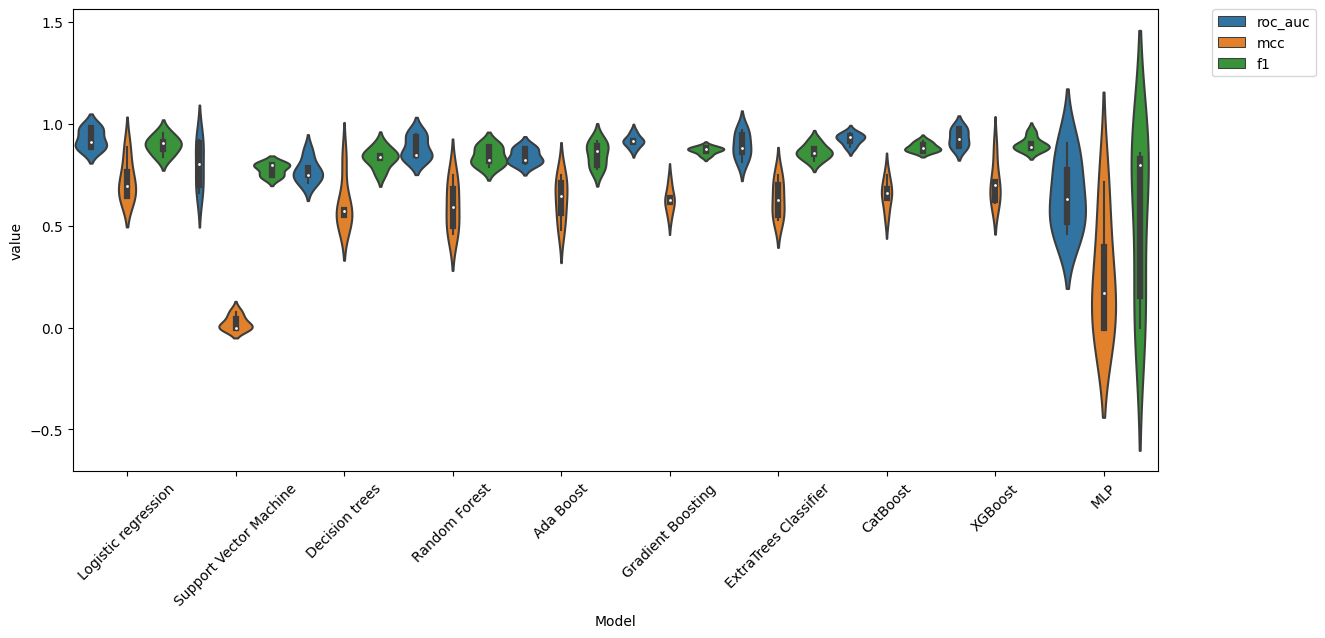

In [26]:
plt.figure(figsize=(14, 6))
# Define a custom color palette for the scores
#score_colors = {"f1": "blue", "precision": "green", "recall": "orange", "accuracy": "red", #"roc_auc": "purple", "mcc": "white"}
sn.violinplot(x="Model", y="value", hue="Score", data=melted_df,
            showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"4"},
            width= 1.0, showfliers=False) 
#plt.title("MCC and AUC_ROC Scores for different Models", fontsize=20)
# Rotate x-axis tick labels
plt.xticks(rotation=45)
# Place legend in the upper right corner outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig("RIF_Cross_val_violin_plot_balanced_dataset.png", dpi=300, bbox_inches="tight")
plt.show()
#plt.title("Isoniazid", fontsize = 20)

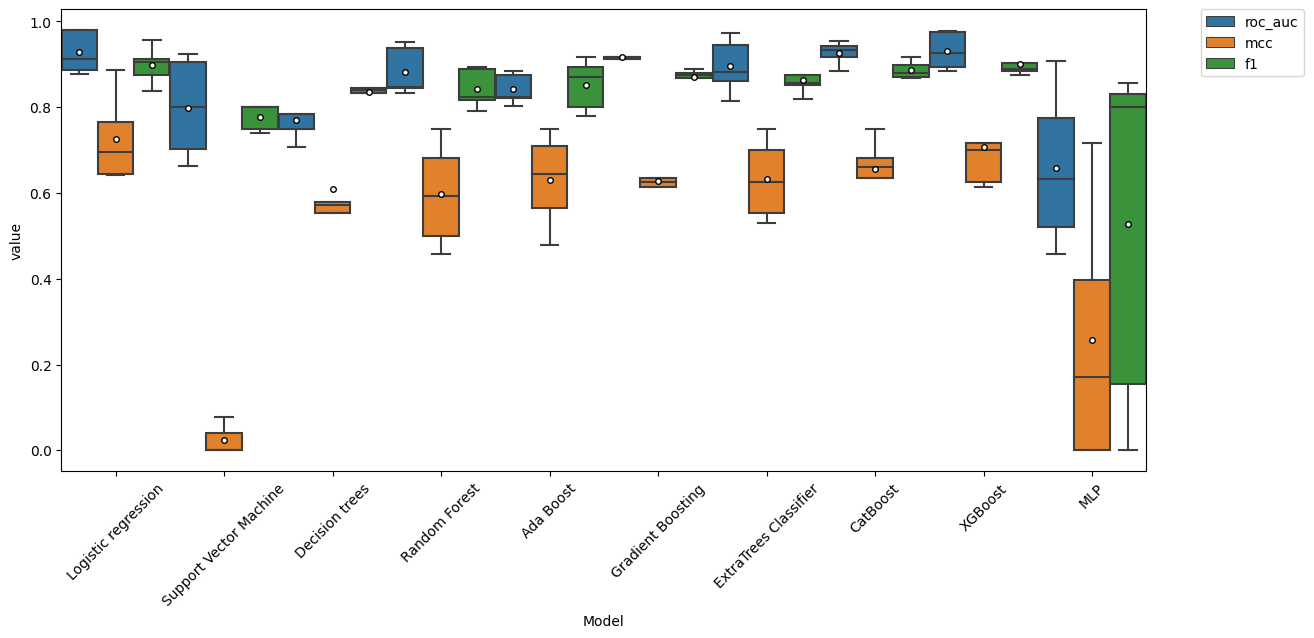

In [27]:
plt.figure(figsize=(14, 6))
# Define a custom color palette for the scores
#score_colors = {"f1": "blue", "precision": "green", "recall": "orange", "accuracy": "red", #"roc_auc": "purple", "mcc": "white"}
sn.boxplot(x="Model", y="value", hue="Score", data=melted_df,
            showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"4"},
            width= 1.0, showfliers=False) 
# Rotate x-axis tick labels
plt.xticks(rotation=45)
#plt.title("MCC and AUC_ROC Scores for different Models", fontsize=20)
# Place legend in the upper right corner outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig("RIF_Cross_val_box_plot_Original.png", dpi=300, bbox_inches="tight")
plt.show()
#plt.title("Isoniazid", fontsize = 20)

# **Handling for class imbalance**

In [57]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled.shape, X_train.shape, y_resampled.shape, y_train.shape

((192, 4997), (145, 4997), (192,), (145,))

In [58]:
y_resampled.value_counts()

0    96
1    96
Name: RIF, dtype: int64

In [28]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, Y)
X_resampled.shape, X.shape, y_resampled.shape, Y.shape

((240, 4997), (182, 4997), (240,), (182,))

In [ ]:
# Function to evaluate models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def Testing_performance(models, X_train, y_train, X_test, y_test):

    results = {}
    for i, (name, classifier) in enumerate(models):
        pipe = Pipeline([('ct', ct), (name, classifier)])
        
        pipe.fit(X_train, y_train)
        y_pred_test = pipe.predict(X_test)
        y_pred_proba_test = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") else [0]*len(X_test)
        
        accuracy = round(accuracy_score(y_test, y_pred_test),2)
        precision = round(precision_score(y_test, y_pred_test),2)
        recall = round(recall_score(y_test, y_pred_test),2)
        f1 = round(f1_score(y_test, y_pred_test),2)
        mcc = round(matthews_corrcoef(y_test, y_pred_test),2)
        auc_roc = round(roc_auc_score(y_test, y_pred_proba_test),2)
        
        results[name] = {
            'accuracy': accuracy,
            'precision': precision, 
            'recall': recall,
            'f1_score': f1,
            'MCC':mcc,
            'auc_roc': auc_roc
        }
    return results

In [ ]:

testing_performance = Testing_performance(models, X_train, y_train, X_test,  y_test)
# Convert the dictionary to a DataFrame
testing_performance = pd.DataFrame.from_dict(testing_performance)

# Transpose the DataFrame to have items in columns as rows and rows as columns
testing_performance_transposed = testing_performance.T

# Display the transposed DataFrame
testing_performance_transposed.head(13)



In [ ]:

testing_performance = Testing_performance(models, X_resampled, y_resampled, X_test,  y_test)
# Convert the dictionary to a DataFrame
testing_performance = pd.DataFrame.from_dict(testing_performance)

# Transpose the DataFrame to have items in columns as rows and rows as columns
testing_performance_transposed = testing_performance.T

# Display the transposed DataFrame
testing_performance_transposed.head(13)

In [ ]:
testing_performance = Testing_performance(models, X_resampled, y_resampled, X_val,  Y_val)
# Convert the dictionary to a DataFrame
testing_performance = pd.DataFrame.from_dict(testing_performance)

# Transpose the DataFrame to have items in columns as rows and rows as columns
testing_performance_transposed = testing_performance.T

# Display the transposed DataFrame
testing_performance_transposed.head(13)

# **External validation dataset performance**

In [113]:
testing_performance_val = Testing_performance(models, X_resampled, y_resampled, X_val,  Y_val)

/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

In [114]:
# Convert the dictionary to a DataFrame
testing_performance_val = pd.DataFrame.from_dict(testing_performance_val)

# Transpose the DataFrame to have items in columns as rows and rows as columns
testing_performance_transposed_val = testing_performance_val.T

# Display the transposed DataFrame
testing_performance_transposed_val.head(13)

,accuracy,precision,recall,f1_score,MCC,auc_roc
Logistic regression,0.83,0.89,0.92,0.90,-0.00,0.48
Suport Vector Machine,0.82,0.90,0.90,0.90,0.05,0.65
Decision trees,0.77,0.88,0.86,0.87,-0.06,0.47
Random Forest,0.89,0.89,1.00,0.94,0.19,0.49
Ada Boost,0.89,0.90,0.99,0.94,0.14,0.89
Gradient Boosting,0.87,0.89,0.98,0.93,-0.05,0.69
ExtraTrees Classifier,0.89,0.89,1.00,0.94,0.00,0.48
CatBoost,0.87,0.90,0.97,0.93,0.08,0.68
XGBoost,0.86,0.91,0.94,0.92,0.20,0.73
Neural networks,0.84,0.89,0.93,0.91,0.01,0.44


In [41]:
# Setting the StratifiedKFold parameter
skfold = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

In [ ]:
scores = ["accuracy", "precision", "recall", "f1",
          "roc_auc", "mcc"]
f1 = [] # To hold the f1-scores for each model
precision = [] # To hold the precision scores for each model
recall = [] # To hold the recall scores for each model
accuracy = [] # To hold the accuracy scores for each model
roc_auc = [] # To hold the roc_auc scores for each model
mcc = []
score_lists = [accuracy, precision, recall, f1, roc_auc, mcc]
for i, (name, classifier) in enumerate(models):
    print(name)
    pipe = Pipeline([('ct', ct), (name, classifier)])
    for index, score in enumerate(scores):
        if score == "mcc":
            cv_score = cross_val_score(pipe, X_resampled, y_resampled, cv=skfold,  
                                       scoring=make_scorer(matthews_corrcoef))
        else:
            cv_score = cross_val_score(pipe, X_resampled, y_resampled, cv=skfold, scoring=score)
        score_lists[index].append(cv_score)
        print(score + " : " + str(np.mean(cv_score)))
    print("\n")

Logistic regression


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

accuracy : 0.9


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

precision : 0.9053069828722002


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

recall : 0.8916666666666668


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

f1 : 0.8980151912754


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

roc_auc : 0.9604166666666666


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

In [ ]:

#'LogR', 'gNB', 'SVM', 'DT', 'RF', 'KNN', 'ADA', 'GBC', 'ETC', 'LGBM', 'CAT', 'Xgboost', 'NN'

# Add all scores to the same dataframe for proper plotting
# Add all scores to the same dataframe for proper plotting
models_names = ['Logistic regression', 'Support Vector Machine', 'Decision trees', 'Random Forest', 
                'Ada Boost', 'Gradient Boosting', 'ExtraTrees Classifier', 'CatBoost',
                'XGBoost', 'MLP']

df_f1 = pd.DataFrame(f1, columns = list(range(5)), index = models_names).T.assign(Score = 'f1')
df_precision = pd.DataFrame(precision, columns = list(range(5)), index = models_names).T.assign(Score = 'precision')
df_recall = pd.DataFrame(recall, columns = list(range(5)), index = models_names).T.assign(Score = 'recall')
df_accuracy = pd.DataFrame(accuracy, columns = list(range(5)), index = models_names).T.assign(Score = 'accuracy')
df_roc = pd.DataFrame(roc_auc, columns = list(range(5)), index = models_names).T.assign(Score = 'roc_auc')

df_mcc = pd.DataFrame(mcc, columns = list(range(5)), index = models_names).T.assign(Score = 'mcc')

#concated_df = pd.concat([df_f1, df_precision, df_recall, df_accuracy, df_roc])

concated_df = pd.concat([df_accuracy, df_f1, df_precision, df_recall, df_roc, df_mcc]) 
melted_df = pd.melt(concated_df, id_vars=['Score'], var_name=['Model']) 
melted_df.to_csv("RIF_Cros_val_scores_balanced_edited.csv")


In [ ]:
concated_df = pd.concat([ df_roc, df_mcc]) 
melted_df = pd.melt(concated_df, id_vars=['Score'], var_name=['Model']) 

In [ ]:
plt.figure(figsize=(14, 6))
# Define a custom color palette for the scores
#score_colors = {"f1": "blue", "precision": "green", "recall": "orange", "accuracy": "red", #"roc_auc": "purple", "mcc": "white"}
sn.violinplot(x="Model", y="value", hue="Score", data=melted_df,
            showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"4"},
            width= 1.0, showfliers=False) 
plt.title("MCC and AUC_ROC Scores for different Models", fontsize=20)
# Rotate x-axis tick labels
plt.xticks(rotation=45)
# Place legend in the upper right corner outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig("RIF_Cross_val_violin_plot_balanced_edited.png", dpi=300, bbox_inches="tight")
plt.show()
#plt.title("Isoniazid", fontsize = 20)

In [ ]:
plt.figure(figsize=(14, 6))
# Define a custom color palette for the scores
#score_colors = {"f1": "blue", "precision": "green", "recall": "orange", "accuracy": "red", #"roc_auc": "purple", "mcc": "white"}
sn.boxplot(x="Model", y="value", hue="Score", data=melted_df,
            showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"4"},
            width= 1.0, showfliers=False) 
plt.title("MCC and AUC_ROC Scores for different Models", fontsize=20)
# Rotate x-axis tick labels
plt.xticks(rotation=45)
# Place legend in the upper right corner outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig("RIF_Cross_val_box_plot_balanced_edited.png", dpi=300, bbox_inches="tight")
plt.show()
#plt.title("Isoniazid", fontsize = 20)

In [24]:
model_rf = RandomForestClassifier()
model_logr =LogisticRegression(random_state=0)
#model_lgbm = LGBMClassifier(random_state=0, n_jobs = -1)
model_xgb = XGBClassifier(random_state=0)
model_gbc = GradientBoostingClassifier(random_state=0)
model_cat = CatBoostClassifier(verbose=False)
model_dt = DecisionTreeClassifier()
model_et = ExtraTreesClassifier()
model_svm = SVC(probability=True)
model_ada = AdaBoostClassifier(random_state=0)
#model_knn = KNeighborsClassifier()
#model_gNB =  GaussianNB()
model_nn= MLPClassifier(random_state=1)


models = []
models.append(('LR', model_logr))
models.append(('SVM', model_svm))
models.append(('DT', model_dt))
models.append(('RF', model_rf))
models.append(('AdaBoost', model_ada))
models.append(('GBC', model_gbc))
models.append(('ETC', model_et))
#models.append(('BC', BaggingClassifier()))
#models.append(('LGBM', model_lgbm))
models.append(('CatBoost', model_cat))
models.append(('XGBoost', model_xgb))
models.append(('MLP', model_nn))


# **Evaluation of model erformance using the test dataset and eval dataset** (Uganda and South Africa)

In [28]:
Columns_to_be_deleted = ['AGE', 'SEX', 'HIV STATUS']
X_val = X_val.drop(Columns_to_be_deleted, axis=1)

In [30]:
model_logr = LogisticRegression(C=10, max_iter=300, random_state=0)
# Fit the model on the training data
model_logr.fit(X_resampled, y_resampled)
# Make predictions
y_test_pred = model_logr.predict(X_test)
y_val_pred = model_logr.predict(X_val)
y_test_prob = model_logr.predict_proba(X_test)[:, 1]
y_val_prob = model_logr.predict_proba(X_val)[:, 1]

/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
X_test.head(n=2)

,POS_371,POS_1228,POS_1552,POS_1849,POS_1977,POS_2532,POS_3446,POS_4013,POS_5078,POS_6112,...,POS_4407873,POS_4407927,POS_4408048,POS_4408087,POS_4408156,POS_4408920,POS_4408923,POS_4409954,POS_4410386,POS_4411016
114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
180,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_val.head(n=2)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.metrics import matthews_corrcoef, roc_auc_score, recall_score, precision_score, accuracy_score, f1_score, confusion_matrix

# Calculate metrics with CIs using bootstrapping
def calculate_metrics_with_ci(y_true, y_pred, y_prob, n_bootstraps=1000, alpha=0.95):
    metrics = {}
    
    # Define metric functions
    metric_functions = {
        'MCC': lambda y_true, y_pred: matthews_corrcoef(y_true, y_pred),
        'ROC AUC': lambda y_true, y_prob: roc_auc_score(y_true, y_prob),
        'Recall': lambda y_true, y_pred: recall_score(y_true, y_pred),
        'Specificity': lambda y_true, y_pred: tn / (tn + fp),
        'Precision': lambda y_true, y_pred: precision_score(y_true, y_pred),
        'Accuracy': lambda y_true, y_pred: accuracy_score(y_true, y_pred),
        'F1 Score': lambda y_true, y_pred: f1_score(y_true, y_pred)
    }

    # Compute metrics and CIs
    for name, func in metric_functions.items():
        scores = []
        for _ in range(n_bootstraps):
            y_true_resampled, y_pred_resampled, y_prob_resampled = resample(y_true, y_pred, y_prob)
            tn, fp, fn, tp = confusion_matrix(y_true_resampled, y_pred_resampled).ravel()
            if name == 'Specificity':
                scores.append(func(y_true_resampled, y_pred_resampled))
            else:
                scores.append(func(y_true_resampled, y_prob_resampled if name == 'ROC AUC' else y_pred_resampled))
        lower = np.percentile(scores, (1 - alpha) / 2 * 100)
        upper = np.percentile(scores, (1 + alpha) / 2 * 100)
        mean_score = np.mean(scores)
        metrics[name] = {
            'mean': mean_score,
            'lower_ci': lower,
            'upper_ci': upper
        }

    return metrics

# Test set metrics with CIs
test_metrics = calculate_metrics_with_ci(y_test, y_test_pred, y_test_prob)

# Validation set metrics with CIs
val_metrics = calculate_metrics_with_ci(Y_val, y_val_pred, y_val_prob)

# Create DataFrame to store results
metrics_df = pd.DataFrame({
    'Metric': ['MCC', 'ROC AUC', 'Recall', 'Specificity', 'Precision', 'Accuracy', 'F1 Score'],
    'Test Set Mean': [test_metrics[metric]['mean'] for metric in ['MCC', 'ROC AUC', 'Recall', 'Specificity', 'Precision', 'Accuracy', 'F1 Score']],
    'Test Set Lower CI': [test_metrics[metric]['lower_ci'] for metric in ['MCC', 'ROC AUC', 'Recall', 'Specificity', 'Precision', 'Accuracy', 'F1 Score']],
    'Test Set Upper CI': [test_metrics[metric]['upper_ci'] for metric in ['MCC', 'ROC AUC', 'Recall', 'Specificity', 'Precision', 'Accuracy', 'F1 Score']],
    'Validation Set Mean': [val_metrics[metric]['mean'] for metric in ['MCC', 'ROC AUC', 'Recall', 'Specificity', 'Precision', 'Accuracy', 'F1 Score']],
    'Validation Set Lower CI': [val_metrics[metric]['lower_ci'] for metric in ['MCC', 'ROC AUC', 'Recall', 'Specificity', 'Precision', 'Accuracy', 'F1 Score']],
    'Validation Set Upper CI': [val_metrics[metric]['upper_ci'] for metric in ['MCC', 'ROC AUC', 'Recall', 'Specificity', 'Precision', 'Accuracy', 'F1 Score']]
})

# Optional: Round the values for better readability
metrics_df = metrics_df.round({'Test Set Mean': 2, 'Test Set Lower CI': 2, 'Test Set Upper CI': 2,
                               'Validation Set Mean': 2, 'Validation Set Lower CI': 2, 'Validation Set Upper CI': 2})

# Display the resulting dataframe
print(metrics_df)


In [ ]:
metrics_df.head(n=10)

In [49]:
from sklearn.utils import resample

# Calculate metrics with CIs using bootstrapping
def calculate_metrics_with_ci(y_true, y_pred, y_prob, n_bootstraps=1000, alpha=0.95):
    metrics = {}
    
    # Define metric functions
    metric_functions = {
        'MCC': lambda y_true, y_pred: matthews_corrcoef(y_true, y_pred),
        'ROC AUC': lambda y_true, y_prob: roc_auc_score(y_true, y_prob),
        'Recall': lambda y_true, y_pred: recall_score(y_true, y_pred),
        'Specificity': lambda y_true, y_pred: tn / (tn + fp),
        'Precision': lambda y_true, y_pred: precision_score(y_true, y_pred),
        'Accuracy': lambda y_true, y_pred: accuracy_score(y_true, y_pred),
        'F1 Score': lambda y_true, y_pred: f1_score(y_true, y_pred)
    }

    # Compute metrics and CIs
    for name, func in metric_functions.items():
        scores = []
        for _ in range(n_bootstraps):
            y_true_resampled, y_pred_resampled, y_prob_resampled = resample(y_true, y_pred, y_prob)
            tn, fp, fn, tp = confusion_matrix(y_true_resampled, y_pred_resampled).ravel()
            if name == 'Specificity':
                scores.append(func(y_true_resampled, y_pred_resampled))
            else:
                scores.append(func(y_true_resampled, y_prob_resampled if name == 'ROC AUC' else y_pred_resampled))
        lower = np.percentile(scores, (1 - alpha) / 2 * 100)
        upper = np.percentile(scores, (1 + alpha) / 2 * 100)
        mean_score = np.mean(scores)
        metrics[name] = f"{round(mean_score, 2)} ± {round((upper - lower) / 2, 2)}"
    
    return metrics

# Test set metrics with CIs
test_metrics = calculate_metrics_with_ci(y_test, y_test_pred, y_test_prob)

# Validation set metrics with CIs
val_metrics = calculate_metrics_with_ci(Y_val, y_val_pred, y_val_prob)

# Create DataFrame to store results
metrics_df = pd.DataFrame({
    'Metric': ['MCC', 'ROC AUC', 'Recall', 'Specificity', 'Precision', 'Accuracy', 'F1 Score'],
    'Test Set': [test_metrics[metric] for metric in ['MCC', 'ROC AUC', 'Recall', 'Specificity', 'Precision', 'Accuracy', 'F1 Score']],
    'Validation Set': [val_metrics[metric] for metric in ['MCC', 'ROC AUC', 'Recall', 'Specificity', 'Precision', 'Accuracy', 'F1 Score']]
})

print(metrics_df)

        Metric     Test Set Validation Set
0          MCC  0.71 ± 0.19    0.07 ± 0.16
1      ROC AUC  0.95 ± 0.07    0.63 ± 0.11
2       Recall  0.75 ± 0.17    0.94 ± 0.03
3  Specificity    1.0 ± 0.0    0.11 ± 0.12
4    Precision    1.0 ± 0.0     0.9 ± 0.04
5     Accuracy  0.84 ± 0.12    0.85 ± 0.04
6     F1 Score  0.85 ± 0.11    0.92 ± 0.03


In [50]:
metrics_df.head(n=10)

,Metric,Test Set,Validation Set
0,MCC,0.71 ± 0.19,0.07 ± 0.16
1,ROC AUC,0.95 ± 0.07,0.63 ± 0.11
2,Recall,0.75 ± 0.17,0.94 ± 0.03
3,Specificity,1.0 ± 0.0,0.11 ± 0.12
4,Precision,1.0 ± 0.0,0.9 ± 0.04
5,Accuracy,0.84 ± 0.12,0.85 ± 0.04
6,F1 Score,0.85 ± 0.11,0.92 ± 0.03


In [39]:
def roc_curves(models, X_train, y_train,X_test, y_test, ct, file_name):
    plt.figure(figsize=(8, 8))

    for i, (name, classifier) in enumerate(models):
        pipe = Pipeline([('ct', ct), (name, classifier)])
        
        pipe.fit(X_train, y_train)
        y_pred_test = pipe.predict(X_test)
        y_pred_proba_test = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") else [0]*len(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Original {name} (AUC = {roc_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    #plt.title('ROC Curves for  Original Datasets')
    plt.legend(loc='lower right')
    plt.savefig(file_name, dpi=300)
    plt.show()
        
        

/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

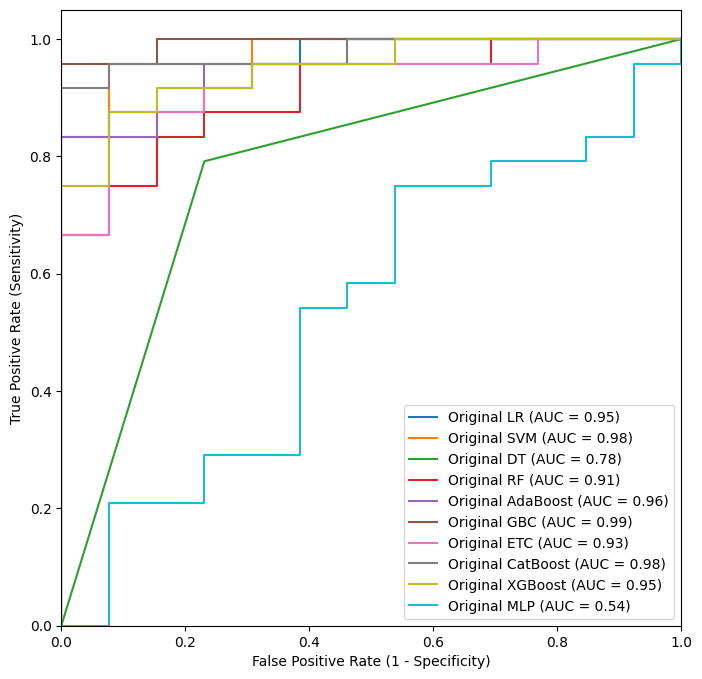

In [40]:
roc_curves(models, X_train, y_train,X_test, y_test, ct, 'Original_dataset_ROC_Plot_RIF.png')

/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

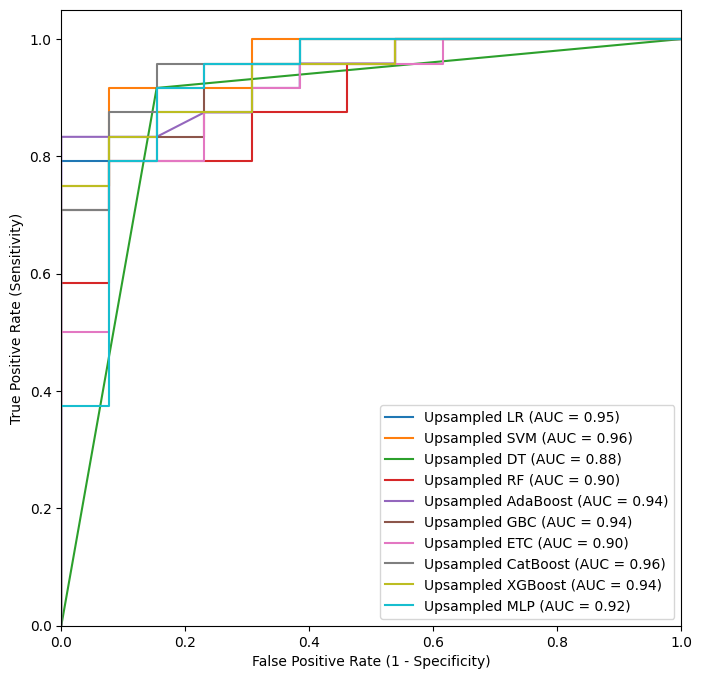

In [41]:
def roc_curves(models, X_train, y_train,X_test, y_test, ct, file_name):
    plt.figure(figsize=(8, 8))

    for i, (name, classifier) in enumerate(models):
        pipe = Pipeline([('ct', ct), (name, classifier)])
        
        pipe.fit(X_train, y_train)
        y_pred_test = pipe.predict(X_test)
        y_pred_proba_test = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") else [0]*len(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Upsampled {name} (AUC = {roc_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    #plt.title('ROC Curves for  Original Datasets')
    plt.legend(loc='lower right')
    plt.savefig(file_name, dpi=300)
    plt.show()
        
roc_curves(models, X_resampled, y_resampled,X_test, y_test, ct, 'Upsampled_dataset_ROC_Plot_RIF.png')

/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

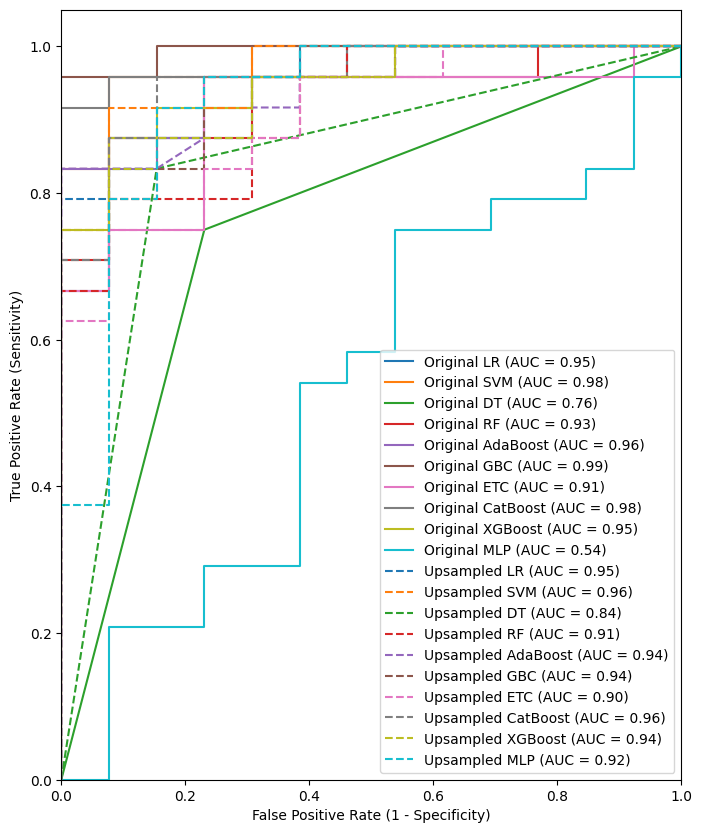

In [42]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_both_roc_curves(models, X_train, y_train,X_test, y_test, X_train_resampled, y_train_resampled, ct):
    plt.figure(figsize=(8, 10))

    # Plot ROC curves for original data
    for i, (name, classifier) in enumerate(models):
        pipe = Pipeline([('ct', ct), (name, classifier)])
        pipe.fit(X_train, y_train)  # Refit using original data
        y_pred_proba_test = pipe.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Original {name} (AUC = {roc_auc:.2f})')

    # Plot ROC curves for UPsampled data
    for i, (name, classifier) in enumerate(models):
        pipe = Pipeline([('ct', ct), (name, classifier)])
        pipe.fit(X_train_resampled, y_train_resampled)  
        y_pred_proba_test = pipe.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linestyle='--', label=f'Upsampled {name} (AUC = {roc_auc:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    #plt.title('ROC Curves for Different Models for Original and Upsampled INH Datasets')
    plt.legend(loc='lower right')
    plt.savefig('Combined_ROC_Plot_RIF.png', dpi=300)
    plt.show()


ROC_CURVES = plot_both_roc_curves(models, X_train, y_train,X_test, y_test, X_resampled, y_resampled, ct)

In [ ]:
def plot_both_roc_curves(models,  X_train_resampled, y_train_resampled, X_test, y_test, X_val, Y_val, ct):
    plt.figure(figsize=(8, 10))

    # Plot ROC curves for original data
    for i, (name, classifier) in enumerate(models):
        pipe = Pipeline([('ct', ct), (name, classifier)])
        pipe.fit(X_train_resampled, y_train_resampled)  # Refit using original data
        y_pred_proba_test = pipe.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'UG {name} (AUC = {roc_auc:.2f})')

    # Plot ROC curves for downsampled data
    for i, (name, classifier) in enumerate(models):
        pipe = Pipeline([('ct', ct), (name, classifier)])
        pipe.fit(X_train_resampled, y_train_resampled)  
        y_pred_proba_test2 = pipe.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(Y_val, y_pred_proba_test2)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linestyle='--', label=f'SA {name} (AUC = {roc_auc:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    #plt.title('ROC Curves for Different Models for Uganda and South Africa Datasets')
    plt.legend(loc='lower right')
    plt.savefig('Combined_ROC_Plot_RIF_val.png', dpi=300)
    plt.show()
ROC_CURVES = plot_both_roc_curves(models,X_resampled, y_resampled,X_test, y_test, X_val, Y_val, ct)

/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

In [34]:
model_rf = RandomForestClassifier(criterion='entropy', max_depth=8, max_features='auto',n_estimators=200)
model_logr = LogisticRegression(C=5, max_iter=100, random_state=0)
model_xgb = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=3, subsample=1.0, random_state=0)
model_gbc = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators = 100, random_state=0, subsample=0.7)
model_cat = CatBoostClassifier(depth=7, iterations=100, l2_leaf_reg=3, learning_rate = 0.1, verbose=False)
model_dt = DecisionTreeClassifier(criterion='gini', max_depth=9)
model_et = ExtraTreesClassifier(criterion='entropy', max_depth=9)
model_svm =SVC(C=1, kernel='linear',probability = True)
model_ada = AdaBoostClassifier(learning_rate=0.1, n_estimators=50, random_state=0)
model_nn= MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 50), random_state=1, solver='adam')

models = []
models.append(('LR', model_logr))
models.append(('SVM', model_svm))
models.append(('DT', model_dt))
models.append(('RF', model_rf))
models.append(('AdaBoost', model_ada))
models.append(('GBC', model_gbc))
models.append(('ETC', model_et))
models.append(('CatBoost', model_cat))
models.append(('XGBoost', model_xgb))
models.append(('MLP', model_nn))


In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
def cross_val_auc(models, X, y, cv, ct):
    auc_scores = {}
    auc_summary = {}

    for i, (name, classifier) in enumerate(models):
        pipe = Pipeline([('ct', ct), (name, classifier)])
        
        #skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc', 
                                 error_score='raise') 
        auc_scores[name] = scores
        mean_score = np.nanmean(scores)
        std_score = np.nanstd(scores)
        confidence_interval = (mean_score - 1.96 * (std_score / np.sqrt(cv)), 
                               mean_score + 1.96 * (std_score / np.sqrt(cv)))

        auc_summary[name] = {
            'AUC Mean': mean_score,
            'AUC Std Dev': std_score,
            'AUC 95% CI Lower': confidence_interval[0],
            'AUC 95% CI Upper': confidence_interval[1]
        }

    return auc_scores, auc_summary

In [27]:
auc_scores_original, auc_summary_original = cross_val_auc(models, X, Y,5,ct)
auc_summary_df_original = pd.DataFrame(auc_summary_original).T
auc_summary_df_original.head(n=13)

/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

,AUC Mean,AUC Std Dev,AUC 95% CI Lower,AUC 95% CI Upper
LR,0.875321,0.073019,0.811317,0.939324
SVM,0.905556,0.061818,0.851370,0.959741
DT,0.704808,0.118244,0.601162,0.808454
RF,0.800962,0.085028,0.726431,0.875492
AdaBoost,0.835069,0.060646,0.781911,0.888228
GBC,0.877671,0.052320,0.831811,0.923531
ETC,0.815545,0.099952,0.727933,0.903157
CatBoost,0.880876,0.047044,0.839640,0.922112
XGBoost,0.897062,0.059088,0.845269,0.948855
MLP,0.527163,0.089994,0.448280,0.606047


In [28]:
auc_summary_df_original = pd.DataFrame(auc_summary_original).T.round(2)
auc_summary_df_original.head(n=13)

,AUC Mean,AUC Std Dev,AUC 95% CI Lower,AUC 95% CI Upper
LR,0.88,0.07,0.81,0.94
SVM,0.91,0.06,0.85,0.96
DT,0.70,0.12,0.60,0.81
RF,0.80,0.09,0.73,0.88
AdaBoost,0.84,0.06,0.78,0.89
GBC,0.88,0.05,0.83,0.92
ETC,0.82,0.10,0.73,0.90
CatBoost,0.88,0.05,0.84,0.92
XGBoost,0.90,0.06,0.85,0.95
MLP,0.53,0.09,0.45,0.61


In [29]:
auc_summary_df_original.to_csv("AUC_CI_Original_dataset_RIF.csv")

In [30]:
auc_scores_train, auc_summary_train = cross_val_auc(models, X_train, y_train, 5, ct)
auc_summary_df_train = pd.DataFrame(auc_summary_train).T
auc_summary_df_train.head(n=13)

/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

,AUC Mean,AUC Std Dev,AUC 95% CI Lower,AUC 95% CI Upper
LR,0.912573,0.031011,0.885391,0.939755
SVM,0.912749,0.048187,0.870511,0.954986
DT,0.689035,0.074183,0.624011,0.754059
RF,0.860058,0.050485,0.815806,0.904311
AdaBoost,0.868246,0.077281,0.800505,0.935986
GBC,0.916023,0.017052,0.901077,0.930970
ETC,0.858363,0.046809,0.817333,0.899393
CatBoost,0.903099,0.034543,0.872821,0.933378
XGBoost,0.929298,0.031234,0.901920,0.956676
MLP,0.521930,0.135088,0.403520,0.640339


In [31]:
auc_summary_df_train = pd.DataFrame(auc_summary_train).T.round(2)
auc_summary_df_train.head(n=13)

,AUC Mean,AUC Std Dev,AUC 95% CI Lower,AUC 95% CI Upper
LR,0.91,0.03,0.89,0.94
SVM,0.91,0.05,0.87,0.95
DT,0.69,0.07,0.62,0.75
RF,0.86,0.05,0.82,0.90
AdaBoost,0.87,0.08,0.80,0.94
GBC,0.92,0.02,0.90,0.93
ETC,0.86,0.05,0.82,0.90
CatBoost,0.90,0.03,0.87,0.93
XGBoost,0.93,0.03,0.90,0.96
MLP,0.52,0.14,0.40,0.64


In [32]:
auc_summary_df_train.to_csv("AUC CI summary for trained dataset RIF.csv")

In [33]:
auc_scores_upsampled, auc_summary_upsampled = cross_val_auc(models, X_resampled, y_resampled, 5, ct)
auc_summary_df_upsampled = pd.DataFrame(auc_summary_upsampled).T
auc_summary_df_upsampled.head(n=13)

/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be remove

,AUC Mean,AUC Std Dev,AUC 95% CI Lower,AUC 95% CI Upper
LR,0.965319,0.031056,0.938097,0.992540
SVM,0.969640,0.027894,0.945190,0.994090
DT,0.818158,0.026765,0.794698,0.841618
RF,0.942161,0.041837,0.905489,0.978833
AdaBoost,0.951537,0.031363,0.924046,0.979028
GBC,0.966593,0.032444,0.938155,0.995031
ETC,0.941634,0.045680,0.901594,0.981675
CatBoost,0.965319,0.028057,0.940726,0.989911
XGBoost,0.968006,0.027150,0.944207,0.991804
MLP,0.577590,0.065572,0.520114,0.635066


In [34]:
auc_summary_df_upsampled = pd.DataFrame(auc_summary_upsampled).T.round(2)
auc_summary_df_upsampled.head(n=13)

,AUC Mean,AUC Std Dev,AUC 95% CI Lower,AUC 95% CI Upper
LR,0.97,0.03,0.94,0.99
SVM,0.97,0.03,0.95,0.99
DT,0.82,0.03,0.79,0.84
RF,0.94,0.04,0.91,0.98
AdaBoost,0.95,0.03,0.92,0.98
GBC,0.97,0.03,0.94,1.00
ETC,0.94,0.05,0.90,0.98
CatBoost,0.97,0.03,0.94,0.99
XGBoost,0.97,0.03,0.94,0.99
MLP,0.58,0.07,0.52,0.64


In [35]:
auc_summary_df_upsampled.to_csv("AUC CI summary for upsampled dataset RIF")

In [36]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def AUC_multiple_comparison_test_csv(auc_scores, output_file):
    model_names = list(auc_scores.keys())
    scores = list(auc_scores.values())
    
    # Flatten the scores into a single list
    scores_flat = [score for model_scores in scores for score in model_scores]
    
    # Create a list of model names repeated for each score
    model_names_flat = [[model_name] * len(scores[i]) for i, model_name in enumerate(model_names)]
    model_names_flat = [model_name for model_names in model_names_flat for model_name in model_names]
    
    # Perform multiple comparison test
    tukey_results = pairwise_tukeyhsd(scores_flat, model_names_flat)
    print(tukey_results)
    
    # Convert Tukey HSD results to a pandas DataFrame
    tukey_results_df = pd.DataFrame(tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
    
    # Save the DataFrame to a CSV file
    tukey_results_df.to_csv(output_file, index=False)

AUC_multiple_comparison_test_csv(auc_scores_original,'Tukey_results_RIF_2024.csv')


  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
AdaBoost CatBoost   0.0458 0.9976 -0.1384    0.23  False
AdaBoost       DT  -0.1303 0.3716 -0.3145   0.054  False
AdaBoost      ETC  -0.0195    1.0 -0.2038  0.1647  False
AdaBoost      GBC   0.0426 0.9986 -0.1416  0.2268  False
AdaBoost       LR   0.0403 0.9991  -0.144  0.2245  False
AdaBoost      MLP  -0.3079 0.0001 -0.4921 -0.1237   True
AdaBoost       RF  -0.0341 0.9998 -0.2183  0.1501  False
AdaBoost      SVM   0.0705 0.9523 -0.1138  0.2547  False
AdaBoost  XGBoost    0.062 0.9788 -0.1222  0.2462  False
CatBoost       DT  -0.1761 0.0714 -0.3603  0.0082  False
CatBoost      ETC  -0.0653 0.9702 -0.2496  0.1189  False
CatBoost      GBC  -0.0032    1.0 -0.1874   0.181  False
CatBoost       LR  -0.0056    1.0 -0.1898  0.1787  False
CatBoost      MLP  -0.3537    0.0  -0.538 -0.1695   True
CatBoost       RF  -0.0799 0.90

In [37]:
AUC_multiple_comparison_test_csv(auc_scores_train,'Tukey_results_trained_RIF_2024.csv')

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
AdaBoost CatBoost   0.0349 0.9986 -0.1153   0.185  False
AdaBoost       DT  -0.1792  0.009 -0.3293 -0.0291   True
AdaBoost      ETC  -0.0099    1.0   -0.16  0.1402  False
AdaBoost      GBC   0.0478 0.9854 -0.1023  0.1979  False
AdaBoost       LR   0.0443 0.9913 -0.1058  0.1944  False
AdaBoost      MLP  -0.3463    0.0 -0.4964 -0.1962   True
AdaBoost       RF  -0.0082    1.0 -0.1583  0.1419  False
AdaBoost      SVM   0.0445 0.9911 -0.1056  0.1946  False
AdaBoost  XGBoost   0.0611 0.9317 -0.0891  0.2112  False
CatBoost       DT  -0.2141 0.0009 -0.3642  -0.064   True
CatBoost      ETC  -0.0447 0.9908 -0.1948  0.1054  False
CatBoost      GBC   0.0129    1.0 -0.1372   0.163  False
CatBoost       LR   0.0095    1.0 -0.1406  0.1596  False
CatBoost      MLP  -0.3812    0.0 -0.5313 -0.2311   True
CatBoost       RF   -0.043  0.9

In [38]:
AUC_multiple_comparison_test_csv(auc_scores_upsampled,'Tukey_results_Upsampled_RIF_2024.csv')

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
AdaBoost CatBoost   0.0138 0.9999 -0.0753  0.1028  False
AdaBoost       DT  -0.1334 0.0004 -0.2224 -0.0443   True
AdaBoost      ETC  -0.0099    1.0  -0.099  0.0792  False
AdaBoost      GBC   0.0151 0.9999  -0.074  0.1041  False
AdaBoost       LR   0.0138 0.9999 -0.0753  0.1028  False
AdaBoost      MLP  -0.3739    0.0  -0.463 -0.2849   True
AdaBoost       RF  -0.0094    1.0 -0.0984  0.0797  False
AdaBoost      SVM   0.0181 0.9995  -0.071  0.1072  False
AdaBoost  XGBoost   0.0165 0.9998 -0.0726  0.1055  False
CatBoost       DT  -0.1472 0.0001 -0.2362 -0.0581   True
CatBoost      ETC  -0.0237 0.9959 -0.1128  0.0654  False
CatBoost      GBC   0.0013    1.0 -0.0878  0.0903  False
CatBoost       LR      0.0    1.0 -0.0891  0.0891  False
CatBoost      MLP  -0.3877    0.0 -0.4768 -0.2987   True
CatBoost       RF  -0.0232 0.99

**MCC Plot after cross validation**

# **Otaining the features of importance**

In [35]:
##Creating a function 
feature_names = X_resampled.columns
def feature_importance(model, feature_names):
    if model == model_cat:
        pipe = Pipeline([('ct', ct),('estimator', model)])
        pipe.fit(X_resampled, y_resampled)
        importance = model.feature_importances_.round(2)
        feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)
    elif model == model_xgb:
        pipe = Pipeline([('ct', ct),('estimator', model)])
        pipe.fit(X_resampled, y_resampled)
        importance = model.feature_importances_.round(2)
        feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)
    else: 
        model.fit(X_resampled, y_resampled)
        importance = model.feature_importances_.round(2)
        feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)
        #Features[model] = pd.DataFrame(feature_names, importance)
    return feature_importance[:10]

In [37]:
gbc_features = feature_importance(model_gbc, feature_names)
print(gbc_features)

[('POS_2155168', 0.22), ('AGE', 0.1), ('POS_2163790', 0.06), ('POS_2523205', 0.06), ('POS_836291', 0.05), ('POS_1165521', 0.03), ('POS_2165286', 0.03), ('POS_3247851', 0.03), ('POS_836272', 0.02), ('POS_2551366', 0.02)]


In [38]:
etc_features = feature_importance(model_et, feature_names)
print(etc_features)

[('POS_2155168', 0.03), ('POS_21795', 0.02), ('POS_71336', 0.02), ('POS_2163790', 0.02), ('POS_2523205', 0.02), ('POS_3590686', 0.02), ('HIV STATUS', 0.01), ('POS_71453', 0.01), ('POS_132417', 0.01), ('POS_234496', 0.01)]


In [36]:
xgb_features = feature_importance(model_xgb, feature_names)
print(xgb_features)

/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[('POS_4307179', 0.09), ('POS_1760923', 0.07), ('POS_4306155', 0.05), ('POS_1760407', 0.04), ('POS_4287017', 0.04), ('POS_599881', 0.03), ('POS_767339', 0.03), ('POS_1616061', 0.03), ('POS_2425471', 0.03), ('POS_1977', 0.02)]


In [39]:
cat_features = cat_var.copy()
# Initialize CatBoostClassifier
model_cat = CatBoostClassifier(depth=9, iterations=50, l2_leaf_reg=2, learning_rate = 0.05, verbose=False)

# Fit the model on the training data
model_cat.fit(X_resampled, y_resampled, cat_features = cat_features)

# Now you can proceed with further operations, such as feature importance
cat_features = feature_importance(model_cat, feature_names)
print(cat_features)


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[('POS_4287017', 12.29), ('POS_4287109', 8.01), ('POS_4306339', 4.01), ('POS_4306155', 3.02), ('POS_1616831', 2.46), ('POS_163670', 1.76), ('POS_1325650', 1.26), ('POS_1761765', 1.21), ('POS_2426630', 1.11), ('POS_33551', 1.03)]


In [40]:
ada_features = feature_importance(model_ada, feature_names)
print(ada_features)

[('POS_2155168', 0.22), ('AGE', 0.16), ('POS_2163790', 0.14), ('POS_761155', 0.12), ('POS_2340621', 0.08), ('POS_71336', 0.06), ('POS_836272', 0.06), ('POS_2523205', 0.06), ('POS_1165521', 0.02), ('POS_2165286', 0.02)]


In [41]:
dc_features = feature_importance(model_dt, feature_names)
print(dc_features)

[('POS_2155168', 0.31), ('POS_2163790', 0.16), ('POS_836291', 0.12), ('POS_976897', 0.05), ('AGE', 0.04), ('POS_969762', 0.04), ('POS_2042049', 0.04), ('POS_2387733', 0.03), ('POS_2532176', 0.03), ('HIV STATUS', 0.02)]


In [42]:
rf_features = feature_importance(model_rf, feature_names)
print(rf_features)

/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[('AGE', 0.02), ('POS_71336', 0.02), ('POS_761155', 0.02), ('POS_2155168', 0.02), ('POS_2163790', 0.02), ('POS_2340621', 0.02), ('POS_2523205', 0.02), ('HIV STATUS', 0.01), ('POS_21795', 0.01), ('POS_71453', 0.01)]


# **Plotting the features of importance**

In [43]:
def plot_feature_importances(importances, model_name, File_name):
    features, scores = zip(*importances)
    
    plt.figure(figsize=(6, 4))
    y_pos = np.arange(len(features))
    
    plt.barh(y_pos, scores, align='center', color="blue")
    plt.yticks(y_pos, features)
    plt.xlabel('Importance Score')
    #plt.title(f'Top 10 Features for {model_name}')
    plt.savefig(File_name, dpi=300)
    
    plt.gca().invert_yaxis()  # To show features from top to bottom
    
    plt.show()

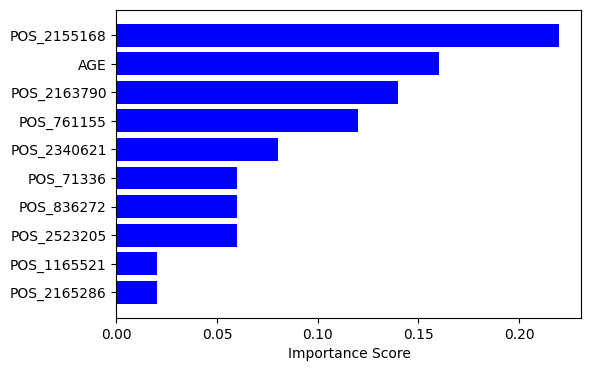

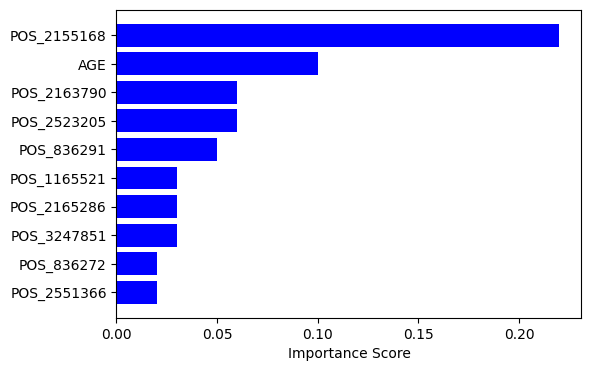

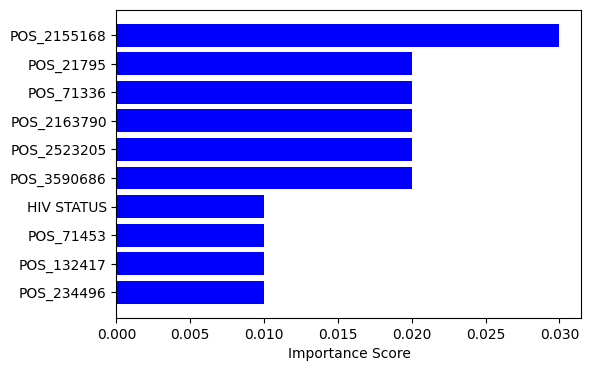

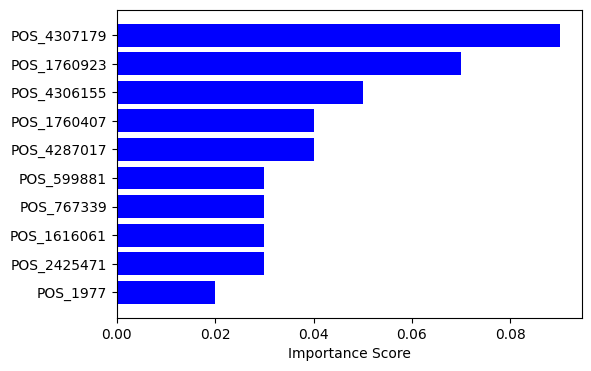

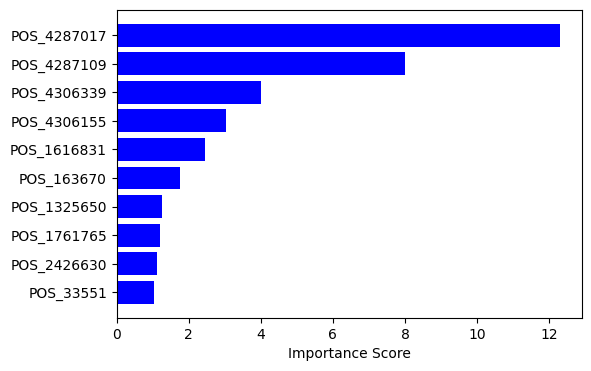

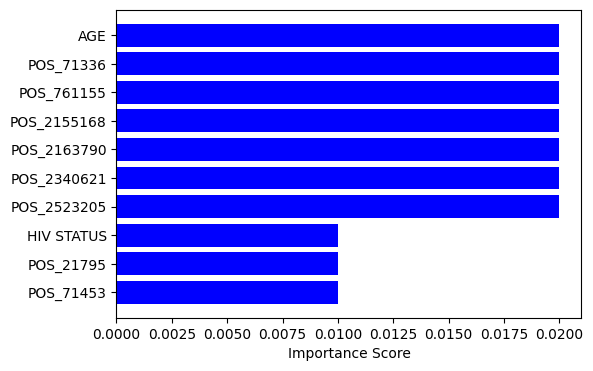

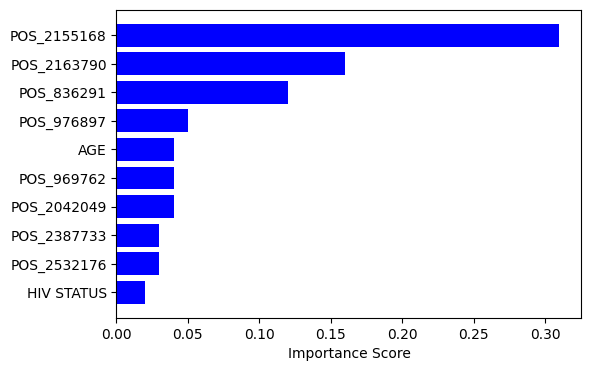

In [44]:
ADA = plot_feature_importances(ada_features,"Adaboost", 'ADA_RIF.png' )
GBC = plot_feature_importances(gbc_features, "Gradient boosting ", 'GBC_RIF.png')
ET = plot_feature_importances(etc_features, "Extra trees", 'ETC_RIF.png')
XGBOOST = plot_feature_importances(xgb_features, "Extreme gradient boosting", 'xgboost_RIF.png')
CAT = plot_feature_importances(cat_features, "Catboost", 'cat_RIF.png')
RF = plot_feature_importances(rf_features, "Random Forest", 'RF_RIF.png')
DC=plot_feature_importances(dc_features, "Decision trees", 'DT_RIF.png')

# **Feature importance plot for logistic regression since it uses coefficients**

/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Top 10 Feature Coefficients:
          Feature  Coefficient
2459  POS_2155168         2.55
2870  POS_2523205         1.67
2474  POS_2163790         1.39
4039  POS_3735802        -1.31
1746  POS_1482627         1.26


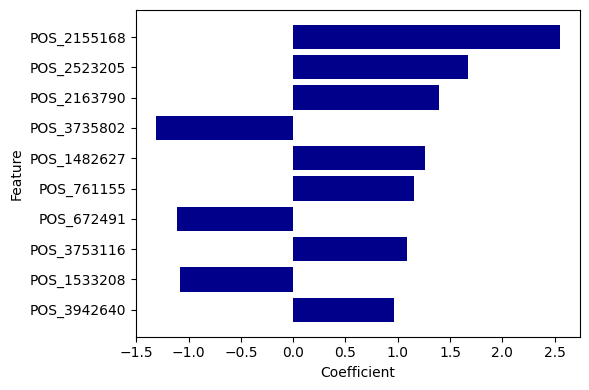

In [41]:
model_logr = LogisticRegression(C=10, max_iter=100, random_state=0)
# Fit the model on the training data
model_logr.fit(X_resampled, y_resampled)

# Access the coefficients and intercept
coefficients = model_logr.coef_[0].round(2)
intercept = model_logr.intercept_[0].round(2)

# Create a DataFrame to display feature coefficients
feature_importance_df = pd.DataFrame({
    'Feature': X_resampled.columns,
    'Coefficient': coefficients
})

# Sort the DataFrame by coefficient magnitude
feature_importance_df = feature_importance_df.reindex(feature_importance_df['Coefficient'].abs().sort_values(ascending=False).index)

# Display the feature coefficients
#print("Feature Coefficients:")
#print(feature_importance_df)

# Create a subset of X_train with only the significant features
significant_features = feature_importance_df.loc[feature_importance_df['Coefficient'] != 0, 'Feature'].tolist()
X_significant = X_resampled[significant_features]


# Select the top 10 features
top_10_features_df = feature_importance_df.head(10)

# Display the top 12 feature coefficients
print("Top 10 Feature Coefficients:")
print(top_10_features_df.head(5))

# Plot the top 10 features with their coefficients
plt.figure(figsize=(6, 4))
plt.barh(top_10_features_df['Feature'], top_10_features_df['Coefficient'], color='darkblue')
#plt.title('Top 10 Feature Coefficients - Logistic Regression')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.gca().invert_yaxis()  # To show features from top to bottom
plt.savefig("RIF_Best_features.png", dpi=300)
plt.show()

In [42]:
#Top 10 features of logR with there coefficients
logr_features = feature_importance_df.head(10)
print(logr_features)

          Feature  Coefficient
2459  POS_2155168         2.55
2870  POS_2523205         1.67
2474  POS_2163790         1.39
4039  POS_3735802        -1.31
1746  POS_1482627         1.26
969    POS_761155         1.16
878    POS_672491        -1.11
4100  POS_3753116         1.09
1785  POS_1533208        -1.08
4334  POS_3942640         0.96


In [47]:
# Convert the dataframe to a list
Logr_features = logr_features.values.tolist()
print(Logr_features)

[['POS_2155168', 2.08], ['POS_2523205', 1.45], ['POS_2163790', 1.2], ['POS_761155', 1.06], ['HIV STATUS', -0.96], ['POS_3753116', 0.94], ['POS_1482627', 0.92], ['POS_1533208', -0.91], ['POS_672491', -0.88], ['POS_3735802', -0.8]]


In [50]:
import pandas as pd

def create_feature_importance_table(importances_list, model_names):
    columns = ['Feature', 'Importance'] * len(model_names)
    table_data = []
    
    for importances in importances_list:
        features, importance_values = zip(*importances)
        table_data.append(features)
        table_data.append(importance_values)
    
    df = pd.DataFrame(table_data).T
    df.columns = columns
    
    return df

In [52]:
importances_list = [ada_features, cat_features, gbc_features, xgb_features, etc_features, rf_features, dc_features,  Logr_features]
model_names = ["Adaboost", "Catboost", "Gradient boosting", "XGBoost", "Extra trees", "Random Forest", "Decision trees",  "Logistic regression"]

feature_importance_df = create_feature_importance_table(importances_list, model_names)
feature_importance_df

,Feature,Importance,Feature,Importance,Feature,Importance,Feature,Importance,Feature,Importance,Feature,Importance,Feature,Importance,Feature,Importance
0,POS_2155168,0.22,POS_4287017,12.29,POS_2155168,0.22,POS_4307179,0.09,POS_2155168,0.03,AGE,0.02,POS_2155168,0.31,POS_2155168,2.08
1,AGE,0.16,POS_4287109,8.01,AGE,0.1,POS_1760923,0.07,POS_21795,0.02,POS_71336,0.02,POS_2163790,0.16,POS_2523205,1.45
2,POS_2163790,0.14,POS_4306339,4.01,POS_2163790,0.06,POS_4306155,0.05,POS_71336,0.02,POS_761155,0.02,POS_836291,0.12,POS_2163790,1.2
3,POS_761155,0.12,POS_4306155,3.02,POS_2523205,0.06,POS_1760407,0.04,POS_2163790,0.02,POS_2155168,0.02,POS_976897,0.05,POS_761155,1.06
4,POS_2340621,0.08,POS_1616831,2.46,POS_836291,0.05,POS_4287017,0.04,POS_2523205,0.02,POS_2163790,0.02,AGE,0.04,HIV STATUS,-0.96
5,POS_71336,0.06,POS_163670,1.76,POS_1165521,0.03,POS_599881,0.03,POS_3590686,0.02,POS_2340621,0.02,POS_969762,0.04,POS_3753116,0.94
6,POS_836272,0.06,POS_1325650,1.26,POS_2165286,0.03,POS_767339,0.03,HIV STATUS,0.01,POS_2523205,0.02,POS_2042049,0.04,POS_1482627,0.92
7,POS_2523205,0.06,POS_1761765,1.21,POS_3247851,0.03,POS_1616061,0.03,POS_71453,0.01,HIV STATUS,0.01,POS_2387733,0.03,POS_1533208,-0.91
8,POS_1165521,0.02,POS_2426630,1.11,POS_836272,0.02,POS_2425471,0.03,POS_132417,0.01,POS_21795,0.01,POS_2532176,0.03,POS_672491,-0.88
9,POS_2165286,0.02,POS_33551,1.03,POS_2551366,0.02,POS_1977,0.02,POS_234496,0.01,POS_71453,0.01,HIV STATUS,0.02,POS_3735802,-0.8


In [54]:
importances_list = [gbc_features,xgb_features, etc_features,  Logr_features]
model_names = ["Gradient boosting", "XGBoost", "Extra trees",  "Logistic regression"]

feature_importance_df = create_feature_importance_table(importances_list, model_names)
feature_importance_df

,Feature,Importance,Feature,Importance,Feature,Importance,Feature,Importance
0,POS_2155168,0.22,POS_4307179,0.09,POS_2155168,0.03,POS_2155168,2.08
1,AGE,0.1,POS_1760923,0.07,POS_21795,0.02,POS_2523205,1.45
2,POS_2163790,0.06,POS_4306155,0.05,POS_71336,0.02,POS_2163790,1.2
3,POS_2523205,0.06,POS_1760407,0.04,POS_2163790,0.02,POS_761155,1.06
4,POS_836291,0.05,POS_4287017,0.04,POS_2523205,0.02,HIV STATUS,-0.96
5,POS_1165521,0.03,POS_599881,0.03,POS_3590686,0.02,POS_3753116,0.94
6,POS_2165286,0.03,POS_767339,0.03,HIV STATUS,0.01,POS_1482627,0.92
7,POS_3247851,0.03,POS_1616061,0.03,POS_71453,0.01,POS_1533208,-0.91
8,POS_836272,0.02,POS_2425471,0.03,POS_132417,0.01,POS_672491,-0.88
9,POS_2551366,0.02,POS_1977,0.02,POS_234496,0.01,POS_3735802,-0.8


In [156]:
feature_importance_df.to_csv("Top_10_features_for_the_best_8_models_RIF.csv")

In [55]:
importances_list = [Logr_features, cat_features, gbc_features, xgb_features]
model_names = ["Logistic regression", "Catboost", "Gradient boosting", "XGBoost"]
feature_importance_df = create_feature_importance_table(importances_list, model_names)
feature_importance_df

,Feature,Importance,Feature,Importance,Feature,Importance,Feature,Importance
0,POS_2155168,2.08,POS_4287017,12.29,POS_2155168,0.22,POS_4307179,0.09
1,POS_2523205,1.45,POS_4287109,8.01,AGE,0.1,POS_1760923,0.07
2,POS_2163790,1.2,POS_4306339,4.01,POS_2163790,0.06,POS_4306155,0.05
3,POS_761155,1.06,POS_4306155,3.02,POS_2523205,0.06,POS_1760407,0.04
4,HIV STATUS,-0.96,POS_1616831,2.46,POS_836291,0.05,POS_4287017,0.04
5,POS_3753116,0.94,POS_163670,1.76,POS_1165521,0.03,POS_599881,0.03
6,POS_1482627,0.92,POS_1325650,1.26,POS_2165286,0.03,POS_767339,0.03
7,POS_1533208,-0.91,POS_1761765,1.21,POS_3247851,0.03,POS_1616061,0.03
8,POS_672491,-0.88,POS_2426630,1.11,POS_836272,0.02,POS_2425471,0.03
9,POS_3735802,-0.8,POS_33551,1.03,POS_2551366,0.02,POS_1977,0.02


In [56]:
sorted_df = feature_importance_df[['Feature']]
print(sorted_df)

       Feature      Feature      Feature      Feature
0  POS_2155168  POS_4287017  POS_2155168  POS_4307179
1  POS_2523205  POS_4287109          AGE  POS_1760923
2  POS_2163790  POS_4306339  POS_2163790  POS_4306155
3   POS_761155  POS_4306155  POS_2523205  POS_1760407
4   HIV STATUS  POS_1616831   POS_836291  POS_4287017
5  POS_3753116   POS_163670  POS_1165521   POS_599881
6  POS_1482627  POS_1325650  POS_2165286   POS_767339
7  POS_1533208  POS_1761765  POS_3247851  POS_1616061
8   POS_672491  POS_2426630   POS_836272  POS_2425471
9  POS_3735802    POS_33551  POS_2551366     POS_1977


In [57]:
all_features = sorted_df.values.flatten().tolist()
# Identify duplicates
duplicates = [item for item in set(all_features) if all_features.count(item) > 1]

# Remove duplicates by converting to a set and then back to a list
unique_features = list(set(all_features))


# Calculate the length of the unique features list
unique_features_length = len(unique_features)
all_features_length = len(all_features)
print("-------------------------------")
print("All Features:", all_features)
print("-------------------------------")
print("Length of combined Features:" , all_features_length)
print("-------------------------------")
print("Unique Features:", unique_features)
print("-------------------------------")
print("Length of Unique Features:", unique_features_length)
print("-------------------------------")
print("Duplicate Features:", duplicates)

-------------------------------
All Features: ['POS_2155168', 'POS_4287017', 'POS_2155168', 'POS_4307179', 'POS_2523205', 'POS_4287109', 'AGE', 'POS_1760923', 'POS_2163790', 'POS_4306339', 'POS_2163790', 'POS_4306155', 'POS_761155', 'POS_4306155', 'POS_2523205', 'POS_1760407', 'HIV STATUS', 'POS_1616831', 'POS_836291', 'POS_4287017', 'POS_3753116', 'POS_163670', 'POS_1165521', 'POS_599881', 'POS_1482627', 'POS_1325650', 'POS_2165286', 'POS_767339', 'POS_1533208', 'POS_1761765', 'POS_3247851', 'POS_1616061', 'POS_672491', 'POS_2426630', 'POS_836272', 'POS_2425471', 'POS_3735802', 'POS_33551', 'POS_2551366', 'POS_1977']
-------------------------------
Length of combined Features: 40
-------------------------------
Unique Features: ['POS_836291', 'POS_1760407', 'POS_2425471', 'POS_2155168', 'POS_1533208', 'POS_1616061', 'POS_2165286', 'POS_163670', 'POS_1616831', 'POS_2523205', 'POS_2551366', 'POS_767339', 'POS_4307179', 'POS_3735802', 'POS_4306339', 'POS_3753116', 'POS_4306155', 'POS_116

In [58]:
# Reduce X_train to selected features
X_train_selected = X_resampled[unique_features]
X_train_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   POS_836291   192 non-null    category
 1   POS_1760407  192 non-null    category
 2   POS_2425471  192 non-null    category
 3   POS_2155168  192 non-null    category
 4   POS_1533208  192 non-null    category
 5   POS_1616061  192 non-null    category
 6   POS_2165286  192 non-null    category
 7   POS_163670   192 non-null    category
 8   POS_1616831  192 non-null    category
 9   POS_2523205  192 non-null    category
 10  POS_2551366  192 non-null    category
 11  POS_767339   192 non-null    category
 12  POS_4307179  192 non-null    category
 13  POS_3735802  192 non-null    category
 14  POS_4306339  192 non-null    category
 15  POS_3753116  192 non-null    category
 16  POS_4306155  192 non-null    category
 17  POS_1165521  192 non-null    category
 18  HIV STATUS   192 non-null    c

In [59]:
# Reduce X_train to selected features
X_test_selected = X_test[unique_features]
X_test_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 114 to 58
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   POS_836291   37 non-null     category
 1   POS_1760407  37 non-null     category
 2   POS_2425471  37 non-null     category
 3   POS_2155168  37 non-null     category
 4   POS_1533208  37 non-null     category
 5   POS_1616061  37 non-null     category
 6   POS_2165286  37 non-null     category
 7   POS_163670   37 non-null     category
 8   POS_1616831  37 non-null     category
 9   POS_2523205  37 non-null     category
 10  POS_2551366  37 non-null     category
 11  POS_767339   37 non-null     category
 12  POS_4307179  37 non-null     category
 13  POS_3735802  37 non-null     category
 14  POS_4306339  37 non-null     category
 15  POS_3753116  37 non-null     category
 16  POS_4306155  37 non-null     category
 17  POS_1165521  37 non-null     category
 18  HIV STATUS   37 non-null     c

## Evaluating the performance of the best model on an external validation dataset with the top 10 features

In [49]:
X_new= X_resampled.loc[:,['POS_2155168','POS_2523205', 'POS_2163790','POS_761155',  'HIV STATUS','POS_3753116','POS_1482627','POS_1533208','POS_672491','POS_3735802']]

In [58]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   POS_2155168  192 non-null    category
 1   POS_2523205  192 non-null    category
 2   POS_2163790  192 non-null    category
 3   POS_761155   192 non-null    category
 4   HIV STATUS   192 non-null    category
 5   POS_3753116  192 non-null    category
 6   POS_1482627  192 non-null    category
 7   POS_1533208  192 non-null    category
 8   POS_672491   192 non-null    category
 9   POS_3735802  192 non-null    category
dtypes: category(10)
memory usage: 3.2 KB


In [111]:
X_val_new= X_val.loc[:,['POS_2155168','POS_2523205', 'POS_2163790','POS_761155',  'HIV STATUS','POS_3753116','POS_1482627','POS_1533208','POS_672491','POS_3735802']]
X_val_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236 entries, 0 to 237
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   POS_2155168  236 non-null    category
 1   POS_2523205  236 non-null    category
 2   POS_2163790  236 non-null    category
 3   POS_761155   236 non-null    category
 4   HIV STATUS   236 non-null    category
 5   POS_3753116  236 non-null    category
 6   POS_1482627  236 non-null    category
 7   POS_1533208  236 non-null    category
 8   POS_672491   236 non-null    category
 9   POS_3735802  236 non-null    category
dtypes: category(10)
memory usage: 5.4 KB


In [68]:

X_test_new= X_test.loc[:,['POS_2155168','POS_2523205', 'POS_2163790','POS_761155',  'HIV STATUS','POS_3753116','POS_1482627','POS_1533208','POS_672491','POS_3735802']]
X_test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 114 to 58
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   POS_2155168  37 non-null     category
 1   POS_2523205  37 non-null     category
 2   POS_2163790  37 non-null     category
 3   POS_761155   37 non-null     category
 4   HIV STATUS   37 non-null     category
 5   POS_3753116  37 non-null     category
 6   POS_1482627  37 non-null     category
 7   POS_1533208  37 non-null     category
 8   POS_672491   37 non-null     category
 9   POS_3735802  37 non-null     category
dtypes: category(10)
memory usage: 1.9 KB


In [82]:
categorical_prefix = 'POS'
categorical_columns = [col for col in X_new.columns if col.startswith(categorical_prefix)]
# Add other categorical columns with different prefixes
categorical_columns += ['HIV STATUS']

cat_var2 = categorical_columns.copy()

In [93]:
onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)
ct = ColumnTransformer([('onehot', onehot, cat_var2)], remainder='passthrough', n_jobs=-1)

In [94]:
pipeline = Pipeline([
    ('preprocessor', ct),
    ('model', model_logr)
])
# Fit the pipeline to your data
pipeline.fit(X_new, y_resampled)

/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['POS_2155168', 'POS_2523205',
                                                   'POS_2163790', 'POS_761155',
                                                   'POS_3753116', 'POS_1482627',
                                                   'POS_1533208', 'POS_672491',
                                                   'POS_3735802',
                                                   'HIV STATUS'])])),
                ('model', LogisticRegression(C=5, random_state=0))])

In [128]:
y_pred_test = pipeline.predict(X_test_new)
y_pred_proba_test = pipeline.predict_proba(X_test_new)[:, 1] 
        
accuracy = round(accuracy_score(y_test, y_pred_test),2)
precision = round(precision_score(y_test, y_pred_test),2)
recall = round(recall_score(y_test, y_pred_test),2)
f1 = round(f1_score(y_test, y_pred_test),2)
mcc = round(matthews_corrcoef(y_test, y_pred_test),2)
auc_roc = round(roc_auc_score(y_test, y_pred_proba_test),2)
        
Results_UG = {
            'accuracy': accuracy,
            'precision': precision, 
            'recall': recall,
            'f1_score': f1,
            'MCC':mcc,
            'auc_roc': auc_roc
        }
print(Results_UG)

{'accuracy': 0.76, 'precision': 0.86, 'recall': 0.75, 'f1_score': 0.8, 'MCC': 0.5, 'auc_roc': 0.83}


In [129]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Metric': ['accuracy ','recall', 'precision', 'MCC', 'f1 Score', 'auc_roc'],
    'Results_UG': [accuracy, recall, precision, mcc, f1,auc_roc ]
    
})

results_df.head(n=6)

,Metric,Results_UG
0,accuracy,0.76
1,recall,0.75
2,precision,0.86
3,MCC,0.50
4,f1 Score,0.80
5,auc_roc,0.83


In [126]:
y_pred_test = pipeline.predict(X_val_new)
y_pred_proba_test = pipeline.predict_proba(X_val_new)[:, 1] 
        
accuracy = round(accuracy_score(Y_val, y_pred_test),2)
precision = round(precision_score(Y_val, y_pred_test),2)
recall = round(recall_score(Y_val, y_pred_test),2)
f1 = round(f1_score(Y_val, y_pred_test),2)
mcc = round(matthews_corrcoef(Y_val, y_pred_test),2)
auc_roc = round(roc_auc_score(Y_val, y_pred_proba_test),2)
        
Results_SA = {
            'accuracy': accuracy,
            'precision': precision, 
            'recall': recall,
            'f1_score': f1,
            'MCC':mcc,
            'auc_roc': auc_roc
        }
print(Results_SA)

{'accuracy': 0.86, 'precision': 0.92, 'recall': 0.93, 'f1_score': 0.92, 'MCC': 0.26, 'auc_roc': 0.86}


In [127]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Metric': ['accuracy ','recall', 'precision', 'MCC', 'f1 Score', 'auc_roc'],
    'Results_SA': [accuracy, recall, precision, mcc, f1,auc_roc ]
    
})

results_df.head(n=6)

,Metric,Results_SA
0,accuracy,0.86
1,recall,0.93
2,precision,0.92
3,MCC,0.26
4,f1 Score,0.92
5,auc_roc,0.86


# **Hyper parameter tuning**

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, matthews_corrcoef

# Define the updated parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.01, 0.2, 0.25, 0.5],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier()

# Define MCC as the scoring metric
scorer = make_scorer(matthews_corrcoef)

# Initialize GridSearchCV with MCC as the scoring metric
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring=scorer, cv=5)

# Fit the model to the training data using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set using the optimized model
y_pred = best_model.predict(X_test)

# Print the best parameters and model MCC
print("Best Parameters:", best_params)
print("Best Model MCC:", matthews_corrcoef(y_test, y_pred))


Best Parameters: {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Best Model MCC: 0.32486683662457994


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, matthews_corrcoef

# Define the updated parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.01, 0.2, 0.25, 0.5],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier()

# Initialize GridSearchCV with MCC as the scoring metric
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring= 'roc_auc', cv=5)

# Fit the model to the training data using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set using the optimized model
y_pred = best_model.predict(X_test)

# Print the best parameters and model MCC
print("Best Parameters:", best_params)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}


# **Hyperparameters for various models**

In [37]:
# Define parameter grids for each classifier
import random
from scipy.stats import randint, uniform

param_dist = {
    'Logistic regression': {
        'C': [0.1, 0.5, 5, 10],
        'max_iter': [100, 300, 500, 1000]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.1, 0.5, 1.0],
        'max_depth': [3,5,7,9],
        'subsample': [0.5, 0.7, 1.0]
    },
    'ExtraTrees Classifier' :{
       'criterion' : ['gini', 'entropy'],
       'max_depth' : [3,7,9] 
    },
    'Suport Vector Machine' :{
       'C': [0.1, 1, 10],
       'kernel': ['linear', 'rbf'],
       'gamma': ['scale', 'auto']
    },
    'Neural networks' :{
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd']
    },
    'Ada Boost' :{
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.1, 0.5, 1.0]   
    },
    'Decision trees' :{
       'criterion' : ['gini', 'entropy'],
       'max_depth' : [3,7,9] 
    },
    'Random Forest' :{
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }
}

In [38]:
model_rf = RandomForestClassifier()
model_logr =LogisticRegression(random_state=0)
model_gbc = GradientBoostingClassifier(random_state=0)
model_dt = DecisionTreeClassifier()
model_et = ExtraTreesClassifier()
model_svm = SVC()
model_ada = AdaBoostClassifier(random_state=0)
model_nn= MLPClassifier(random_state=1)


models = []
models.append(('Logistic regression', model_logr))
models.append(('Suport Vector Machine', model_svm))
models.append(('Decision trees', model_dt))
models.append(('Random Forest', model_rf))
models.append(('Ada Boost', model_ada))
models.append(('Gradient Boosting', model_gbc))
models.append(('ExtraTrees Classifier', model_et))
models.append(('Neural networks', model_nn))


In [39]:
%%time

from sklearn.model_selection import GridSearchCV
best_params = {}  # Initialize a dictionary to store the best parameters for each model
best_model = {}
best_score = {}

# Initialize an empty list to store the AUC scores and parameters
auc_scores = []
params = []

for i, (name, classifier) in enumerate(models):
    print(name)
    grid_search = GridSearchCV(classifier, param_dist[name], cv=5, verbose=1, 
                               scoring='roc_auc')

    grid_search.fit(X_train, y_train)

    # Update the best_params dictionary with the best parameters for each model
    best_params[name] = grid_search.best_params_
    best_model[name]= grid_search.best_estimator_
    best_score[name] = grid_search.best_score_

    #print(f"Best Score: {best_score[name]}")


Logistic regression
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Suport Vector Machine
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Decision trees
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Random Forest
Fitting 5 folds for each of 90 candidates, totalling 450 fits


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

Ada Boost
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Gradient Boosting
Fitting 5 folds for each of 108 candidates, totalling 540 fits
ExtraTrees Classifier
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Neural networks
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sandra.bab

CPU times: user 13h 20min 11s, sys: 1min 29s, total: 13h 21min 40s
Wall time: 4h 8min 6s


In [40]:
print(best_params)
print(best_score)
print(best_model)

{'Logistic regression': {'C': 10, 'max_iter': 100}, 'Suport Vector Machine': {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}, 'Decision trees': {'criterion': 'entropy', 'max_depth': 7}, 'Random Forest': {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 100}, 'Ada Boost': {'learning_rate': 0.1, 'n_estimators': 300}, 'Gradient Boosting': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}, 'ExtraTrees Classifier': {'criterion': 'entropy', 'max_depth': 9}, 'Neural networks': {'activation': 'relu', 'hidden_layer_sizes': (100, 50), 'solver': 'adam'}}
{'Logistic regression': 0.9094152046783627, 'Suport Vector Machine': 0.9128070175438596, 'Decision trees': 0.7514912280701755, 'Random Forest': 0.8319298245614034, 'Ada Boost': 0.8768421052631579, 'Gradient Boosting': 0.9126900584795322, 'ExtraTrees Classifier': 0.8476023391812865, 'Neural networks': 0.8480701754385965}
{'Logistic regression': LogisticRegression(C=10, random_state=0), 'Sup

# **These are the best parameters for LogR, GBC and ETC**

In [21]:
%%time
# Initialize XGBoost as the estimator
model_xgb = XGBClassifier(random_state=0)

# Define hyperparameter grid for XGBoost
param_dist = {
    'n_estimators': [100,300, 500],
    'learning_rate': [0.1, 0.3, 0.5],
    'max_depth':[3,5,9],
    'subsample': [0.8, 0.9, 1.0]
}

# Create the Pipeline with XGBoost as the estimator
pipe = Pipeline([
    ('ct', ct),
    ('estimator', model_xgb)
])

# Adjust the parameter names for GridSearchCV
param_grid = {f'estimator__{key}': value for key, value in param_dist.items()}

# Perform GridSearchCV with XGBoost as the estimator
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, verbose=1, scoring='roc_auc', n_jobs = -1)
grid_search.fit(X_train, y_train)

best_params_xgb = grid_search.best_params_
best_score_xgb = grid_search.best_score_

print(f"Best Score: {best_score_xgb}")
model_xgb.set_params(**best_params_xgb)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sp

Best Score: 0.9292982456140351
CPU times: user 3min 17s, sys: 9.09 s, total: 3min 26s
Wall time: 12min 46s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, estimator__learning_rate=0.3,
              estimator__max_depth=3, estimator__n_estimators=100,
              estimator__subsample=1.0, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, ...)


# **This is the output from running the code of hyper parameter tuning for xgboost**
Best Score: 0.775
Time: 
CPU times: user 3min 49s, sys: 4.95 s, total: 3min 54s
Wall time: 7min 13s

XGBClassifier
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, estimator__learning_rate=0.1,
              estimator__max_depth=5, estimator__n_estimators=500,
              estimator__subsample=0.8, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, ...)

best_parameters: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 500, 'estimator__subsample': 0.8}

In [22]:
print(best_params_xgb)

{'estimator__learning_rate': 0.3, 'estimator__max_depth': 3, 'estimator__n_estimators': 100, 'estimator__subsample': 1.0}


In [83]:
cat_features = cat_var.copy()

In [84]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Initialize CatBoost as the estimator
model_cat = CatBoostClassifier(random_state=0, verbose=False)

param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 7, 9],
    'l2_leaf_reg': [2, 3, 4],
    'iterations': [10, 50, 100]
}

# Identify the categorical features
#cat_features = ['HIV STATUS']  # Add the categorical feature(s) here

# Perform GridSearchCV with CatBoost as the estimator
grid_search = GridSearchCV(model_cat, param_dist, cv=5, verbose=1, scoring='roc_auc', error_score='raise')

# Fit the model with cat_features
grid_search.fit(X_train, y_train, cat_features=cat_features)

# Update the best_params dictionary with the best parameters for the model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

best_score = grid_search.best_score_

print(f"Best Score: {best_score}")
model_cat.set_params(**best_params)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Score: 0.9111111111111111


In [85]:
print(best_params)
print(best_score)
print(best_model)

{'depth': 7, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
0.9111111111111111
